In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy

## load data

In [2]:
# file locations
    #Csec
        #rho
Csec_rho_gene_and_flank = pd.read_csv('./Csec/20230810_Csec_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t')
Csec_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/rho_per_gene/20230717_Csec_rho_exons_and_introns.tsv', sep='\t', index_col=0)
Csec_rho_exon_and_intron.columns = ['scaffold', 'source', 'featuretype', 'start', 'stop', 'n', 'strand', 'n2', 'ID', 'scaffold_alt', 'rho']
        #CpG
Csec_CpG_gene_and_flank = pd.read_csv( './Csec/20230810_Csec_CpG_per_gene_and_50kbflank_10kbbuffer.tsv', sep='\t', index_col=0)
Csec_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/20230717_Csec_CpG_exons_and_introns.tsv', sep='\t', index_col=0)

    #Mbel
        #rho
Mbel_rho_gene_and_flank = pd.read_csv('./Mbel/20230810_Mbel_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_rho_exons_and_introns.tsv', sep='\t',index_col=0)
        #CpG
Mbel_CpG_gene_and_flank = pd.read_csv('./Mbel/20230811_Mbel_CpG_per_gene_and_5okbflank_and_10kb_buffer_18batchmiss.tsv', sep='\t',index_col=0)
Mbel_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t',index_col=0)


#### format Csec

In [3]:
Csec_gene_and_flank = pd.merge(left=Csec_rho_gene_and_flank, right=Csec_CpG_gene_and_flank, left_on='idstring', right_on='ID')

In [4]:
Csec_exin = pd.merge(left=Csec_CpG_exon_and_intron, right=Csec_rho_exon_and_intron, left_on=['ID','featuretype'], right_on=['ID','featuretype'])

In [5]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [6]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [7]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [8]:
# remnove superfluous columns
Csec_gene_and_flank = Csec_gene_and_flank[['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID']]

In [9]:
# rename scaffold and rho columns to avoid issues down the line
Csec_exin.columns = ['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold2', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'scaffold', 'weighted_mean_rho_gene', 'GeneID']

In [10]:
# remnove superfluous columns
Csec_exin = Csec_exin[['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe','source', 'start', 'stop', 'n', 'strand', 'n2','scaffold', 'weighted_mean_rho_gene', 'GeneID']]

In [11]:
Csec_gene_and_flank['featuretype'] = ['gene' for i in range(Csec_gene_and_flank.shape[0])]

In [12]:
merged_Csec = pd.concat([Csec_gene_and_flank, Csec_exin])

#### format Mbel

In [13]:
Mbel_rho_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID']
Mbel_gene_and_flank = pd.merge(left=Mbel_rho_gene_and_flank, right=Mbel_CpG_gene_and_flank, left_on='ID', right_on='ID')
Mbel_exin = pd.merge(left=Mbel_CpG_exon_and_intron, right=Mbel_rho_exon_and_intron, left_on=['ID'], right_on=['ID'])

In [14]:
def split_id(ID, featuretype=False):
    gene =  ID.rsplit('.',1)[0]
    ft =  ID.rsplit('.',1)[1]
    if featuretype==True:
        #strip number of intron/exon id to get only the type
        return ''.join([i for i in ft if not i.isdigit()])
    else:
        return gene

In [15]:
Mbel_exin.columns = ['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype',
       'Start_pos', 'End_pos', 'GeneID', 'weighted_mean_rho_gene']

In [16]:
Mbel_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'GeneID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe']

In [17]:
Mbel_gene_and_flank['featuretype'] = ['gene' for i in range(Mbel_gene_and_flank.shape[0])]

In [18]:
merged_Mbel = pd.concat([Mbel_exin,Mbel_gene_and_flank])

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
#merged_Mbel.to_csv('merged_mbel_with_mean.tsv', sep='\t')

In [24]:
#merged_Csec.to_csv('merged_csec_with_mean.tsv', sep='\t')

In [20]:
mean_rho_flank = []
mean_cpg_flank = []
for i, k in merged_Csec.iterrows():
    if k['weighted_mean_rho_uflank'] == np.nan:
        if k['weighted_mean_rho_dflank'] == np.nan:
            mean_rho_flank.append(np.nan)
        else:
             mean_rho_flank.append(k['weighted_mean_rho_dflank'])
    
    else:
        if k['weighted_mean_rho_dflank'] == np.nan:
             mean_rho_flank.append(k['weighted_mean_rho_uflank'])
        else:
             mean_rho_flank.append(np.mean([k['weighted_mean_rho_uflank'],k['weighted_mean_rho_dflank']]))

    
    if k['flank_u_cpg_oe'] == np.nan:
        if k['flank_d_cpg_oe'] == np.nan:
            mean_cpg_flank.append(np.nan)
        else:
             mean_cpg_flank.append(k['flank_d_cpg_oe'])
    
    else:
        if k['flank_d_cpg_oe'] == np.nan:
             mean_cpg_flank.append(k['flank_u_cpg_oe'])
        else:
             mean_cpg_flank.append(np.mean([k['flank_u_cpg_oe'],k['flank_d_cpg_oe']]))


    
merged_Csec['mean_rho_flank'] = mean_rho_flank
merged_Csec['mean_cpg_flank'] = mean_cpg_flank

In [21]:
mean_rho_flank = []
mean_cpg_flank = []
for i, k in merged_Mbel.iterrows():
    if k['weighted_mean_rho_uflank'] == np.nan:
        if k['weighted_mean_rho_dflank'] == np.nan:
            mean_rho_flank.append(np.nan)
        else:
             mean_rho_flank.append(k['weighted_mean_rho_dflank'])
    
    else:
        if k['weighted_mean_rho_dflank'] == np.nan:
             mean_rho_flank.append(k['weighted_mean_rho_uflank'])
        else:
             mean_rho_flank.append(np.mean([k['weighted_mean_rho_uflank'],k['weighted_mean_rho_dflank']]))

    
    if k['flank_u_cpg_oe'] == np.nan:
        if k['flank_d_cpg_oe'] == np.nan:
            mean_cpg_flank.append(np.nan)
        else:
             mean_cpg_flank.append(k['flank_d_cpg_oe'])
    
    else:
        if k['flank_d_cpg_oe'] == np.nan:
             mean_cpg_flank.append(k['flank_u_cpg_oe'])
        else:
             mean_cpg_flank.append(np.mean([k['flank_u_cpg_oe'],k['flank_d_cpg_oe']]))


    
merged_Mbel['mean_rho_flank'] = mean_rho_flank
merged_Mbel['mean_cpg_flank'] = mean_cpg_flank

## plot

In [33]:
Mbel_melt = merged_Mbel.melt(value_vars=['gene_cpg_oe','weighted_mean_rho_gene' ,'mean_rho_flank','mean_cpg_flank'], id_vars=['GeneID', 'scaffold','featuretype']).replace('no_overlap_bin', np.nan)
Mbel_melt.value = Mbel_melt.value.astype(float)

ft2 = []
for i,k in Mbel_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
Mbel_melt['ft2'] = ft2

(0.0, 2.0)

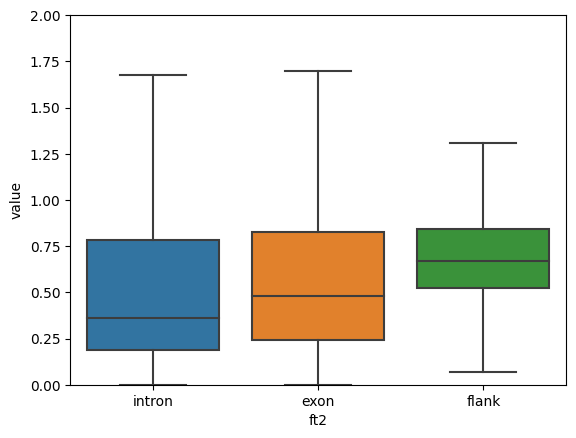

In [43]:
sns.boxplot(data=Mbel_melt.loc[Mbel_melt.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[Mbel_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0)
plt.ylim(0,2)

(0.0, 6.0)

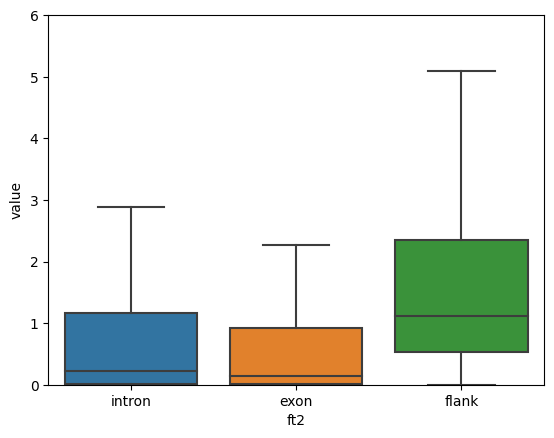

In [47]:
sns.boxplot(data=Mbel_melt.loc[Mbel_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[Mbel_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0)
plt.ylim(0,6)

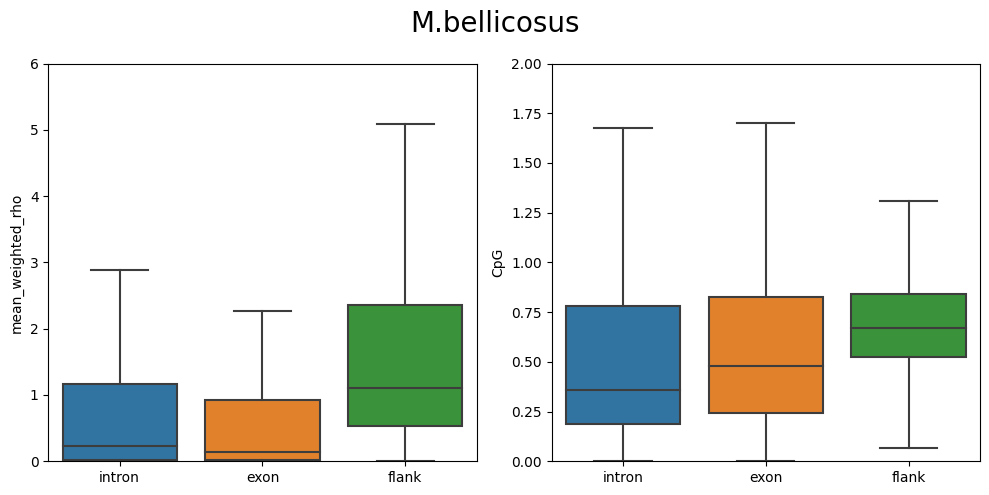

In [58]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.boxplot(data=Mbel_melt.loc[Mbel_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[Mbel_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax)

sns.boxplot(data=Mbel_melt.loc[Mbel_melt.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[Mbel_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax1)
ax.set_ylabel('mean_weighted_rho')
ax1.set_ylabel('CpG')

ax.set_xlabel('')
ax1.set_xlabel('')

ax.set_ylim(0,6)
ax1.set_ylim(0,2)

fig.suptitle('M.bellicosus', size=20)
plt.tight_layout()
plt.show()

In [24]:
Mbel_melt.loc[Mbel_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].value.replace('no_overlap_bin', np.nan).astype(float)

530469     0.098135
530470     0.101440
530471     0.231845
530472     0.308049
530473     0.221740
             ...   
1591402    0.211561
1591403    0.109913
1591404    0.109913
1591405    0.109913
1591406    0.684133
Name: value, Length: 1060938, dtype: float64

(0.0, 6.0)

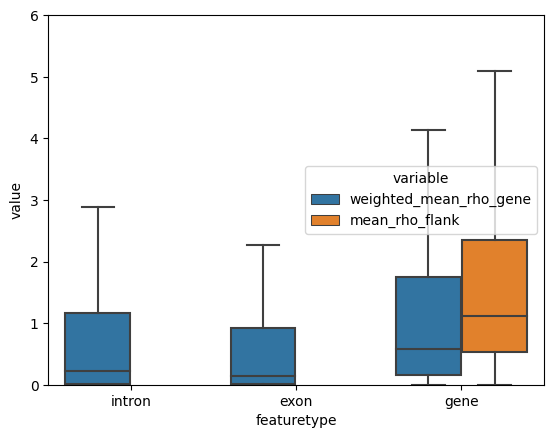

In [85]:
sns.boxplot(data=Mbel_melt.loc[Mbel_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])], y='value', x='featuretype', hue='variable', fliersize=0)
plt.ylim(0,6)

In [24]:
DEdf = pd.read_csv('./Mbel/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)
DEdf = DEdf.dropna(subset=['sgo'])
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']

DEdf['queen_biased'] = DEdf[['queen_upregulated_vs_king', 'queen_upregulated_vs_majorworker', 'queen_upregulated_vs_minorworker']].sum(axis=1).astype(bool)
DEdf['king_biased'] = DEdf[['king_upregulated_vs_queen', 'king_upregulated_vs_majorworker', 'king_upregulated_vs_minorworker']].sum(axis=1).astype(bool)
DEdf['worker_biased'] = DEdf[['majorworker_upregulated_vs_king', 'majorworker_upregulated_vs_queen', 'minorworker_upregulated_vs_king', 'minorworker_upregulated_vs_queen']].sum(axis=1).astype(bool)
DEdf['male_biased'] = DEdf[['king_upregulated_vs_queen']].sum(axis=1).astype(bool)
DEdf['female_biased'] = DEdf[['queen_upregulated_vs_king']].sum(axis=1).astype(bool)
DEdf['reproduction_biased'] = DEdf[['queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker', 'king_upregulated_vs_minorworker', 'queen_upregulated_vs_minorworker']].sum(axis=1).astype(bool)

DE_sgo = DEdf.loc[DEdf.sgo==True]

DE_Mbel = merged_Mbel.merge(DE_sgo, left_on='GeneID', right_on='orthologues')
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)

In [60]:
DE_Mbel

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues,queen_biased,king_biased,worker_biased,male_biased,female_biased,reproduction_biased
0,g4861.t1.exon1,0.857143,0,0.000000,scaffold5,exon,17622247.0,17622261.0,g4861.t1,2.278240,...,True,True,False,g4861.t1,True,True,False,False,True,True
1,g4861.t1.intron1,125.690391,86,0.684221,scaffold5,intron,17622262.0,17625634.0,g4861.t1,1.652539,...,True,True,False,g4861.t1,True,True,False,False,True,True
2,g4861.t1.exon2,6.967742,1,0.143519,scaffold5,exon,17625635.0,17625790.0,g4861.t1,0.010810,...,True,True,False,g4861.t1,True,True,False,False,True,True
3,g4861.t1.intron2,38.965517,9,0.230973,scaffold5,intron,17625791.0,17626951.0,g4861.t1,0.008107,...,True,True,False,g4861.t1,True,True,False,False,True,True
4,g4861.t1.exon3,5.657143,1,0.176768,scaffold5,exon,17626952.0,17627057.0,g4861.t1,0.006560,...,True,True,False,g4861.t1,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94999,g2881.t1.intron8,26.697303,6,0.224742,scaffold11,intron,28563531.0,28564532.0,g2881.t1,1.625669,...,False,False,False,g2881.t1,False,False,False,False,False,False
95000,g2881.t1.exon9,4.413043,0,0.000000,scaffold11,exon,28564533.0,28564625.0,g2881.t1,1.808020,...,False,False,False,g2881.t1,False,False,False,False,False,False
95001,g2881.t1.intron9,55.170732,18,0.326260,scaffold11,intron,28564626.0,28566676.0,g2881.t1,0.292779,...,False,False,False,g2881.t1,False,False,False,False,False,False
95002,g2881.t1.exon10,4.301205,3,0.697479,scaffold11,exon,28566677.0,28566760.0,g2881.t1,0.042660,...,False,False,False,g2881.t1,False,False,False,False,False,False


In [25]:
DEtypes = ['queen_biased','king_biased','worker_biased', 'male_biased', 'female_biased', 'reproduction_biased']

In [62]:
DE_Mbel_melt = DE_Mbel.melt(id_vars=['orthologues', 'GeneID', 'featuretype']+DEtypes, value_vars=['gene_cpg_oe','weighted_mean_rho_gene', 'mean_cpg_flank','mean_rho_flank' ])

In [64]:
ft2 = []
for i,k in DE_Mbel_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
DE_Mbel_melt['ft2'] = ft2

In [67]:
DE_Mbel_melt

,orthologues,GeneID,featuretype,queen_biased,king_biased,worker_biased,male_biased,female_biased,reproduction_biased,variable,value,ft2
0,g4861.t1,g4861.t1,exon,True,True,False,False,True,True,gene_cpg_oe,0.000000,exon
1,g4861.t1,g4861.t1,intron,True,True,False,False,True,True,gene_cpg_oe,0.684221,intron
2,g4861.t1,g4861.t1,exon,True,True,False,False,True,True,gene_cpg_oe,0.143519,exon
3,g4861.t1,g4861.t1,intron,True,True,False,False,True,True,gene_cpg_oe,0.230973,intron
4,g4861.t1,g4861.t1,exon,True,True,False,False,True,True,gene_cpg_oe,0.176768,exon
...,...,...,...,...,...,...,...,...,...,...,...,...
380011,g2881.t1,g2881.t1,intron,False,False,False,False,False,False,mean_rho_flank,NaN,flank
380012,g2881.t1,g2881.t1,exon,False,False,False,False,False,False,mean_rho_flank,NaN,flank
380013,g2881.t1,g2881.t1,intron,False,False,False,False,False,False,mean_rho_flank,NaN,flank
380014,g2881.t1,g2881.t1,exon,False,False,False,False,False,False,mean_rho_flank,NaN,flank


In [26]:
DE_Mbel

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues,queen_biased,king_biased,worker_biased,male_biased,female_biased,reproduction_biased
0,g4861.t1.exon1,0.857143,0,0.000000,scaffold5,exon,17622247.0,17622261.0,g4861.t1,2.278240,...,True,True,False,g4861.t1,True,True,False,False,True,True
1,g4861.t1.intron1,125.690391,86,0.684221,scaffold5,intron,17622262.0,17625634.0,g4861.t1,1.652539,...,True,True,False,g4861.t1,True,True,False,False,True,True
2,g4861.t1.exon2,6.967742,1,0.143519,scaffold5,exon,17625635.0,17625790.0,g4861.t1,0.010810,...,True,True,False,g4861.t1,True,True,False,False,True,True
3,g4861.t1.intron2,38.965517,9,0.230973,scaffold5,intron,17625791.0,17626951.0,g4861.t1,0.008107,...,True,True,False,g4861.t1,True,True,False,False,True,True
4,g4861.t1.exon3,5.657143,1,0.176768,scaffold5,exon,17626952.0,17627057.0,g4861.t1,0.006560,...,True,True,False,g4861.t1,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94999,g2881.t1.intron8,26.697303,6,0.224742,scaffold11,intron,28563531.0,28564532.0,g2881.t1,1.625669,...,False,False,False,g2881.t1,False,False,False,False,False,False
95000,g2881.t1.exon9,4.413043,0,0.000000,scaffold11,exon,28564533.0,28564625.0,g2881.t1,1.808020,...,False,False,False,g2881.t1,False,False,False,False,False,False
95001,g2881.t1.intron9,55.170732,18,0.326260,scaffold11,intron,28564626.0,28566676.0,g2881.t1,0.292779,...,False,False,False,g2881.t1,False,False,False,False,False,False
95002,g2881.t1.exon10,4.301205,3,0.697479,scaffold11,exon,28566677.0,28566760.0,g2881.t1,0.042660,...,False,False,False,g2881.t1,False,False,False,False,False,False


In [68]:
len(DEtypes)

6

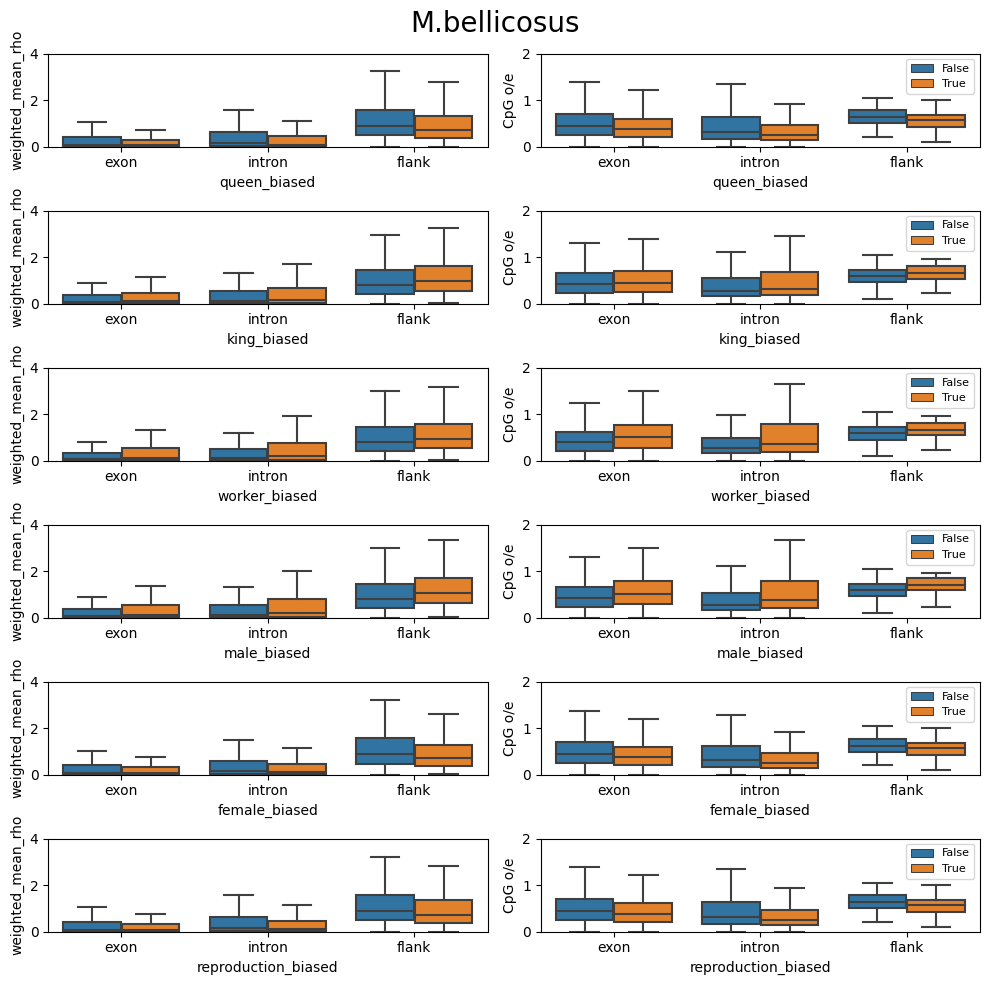

In [81]:
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(10, 10), sharex=False, sharey='col')
for i, k  in enumerate(DEtypes):
    #ss_de = DE_Mbel_melt.loc[DE_Mbel_melt[k]==True]
    ss_de = DE_Mbel_melt

    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax= axes[i,0])
    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax=axes[i,1])
    #sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    #sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='exon'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='intron'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='gene'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'purple', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'purple'}, label='gene')
    
    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2)
    axes[i,0].set_xlabel(k)

    axes[i,0].set_ylabel('weighted_mean_rho')
    axes[i,1].set_ylabel('CpG o/e')
    axes[i,1].set_xlabel(k)
    #axes[i,2].set_xlabel(k)
    #axes[i,2].set_ylim(0,10)
    #axes[i,2].set_xlim(0,10)
    #axes[i,2].legend(fontsize=8)
plt.suptitle('M.bellicosus', fontsize=20)
#plt.savefig('./figures/20230810_Mbel_DE_panel.png',bbox_inches='tight')
#plt.savefig('./figures/20230810_Mbel_DE_panel.svg',bbox_inches='tight')
plt.tight_layout()
plt.show()

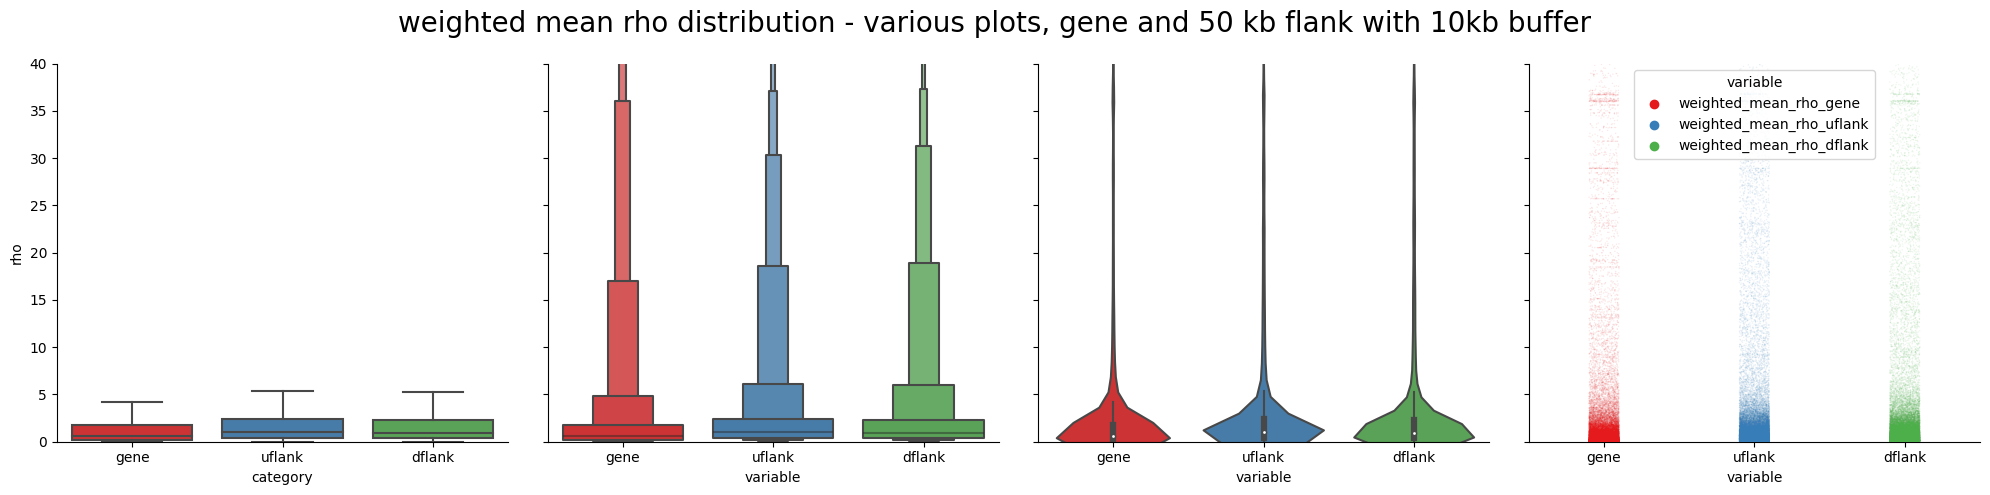

In [29]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax.set_xlabel('category')
ax.set_ylim(0,40)

fig.suptitle('weighted mean rho distribution - various plots, gene and 50 kb flank with 10kb buffer', size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

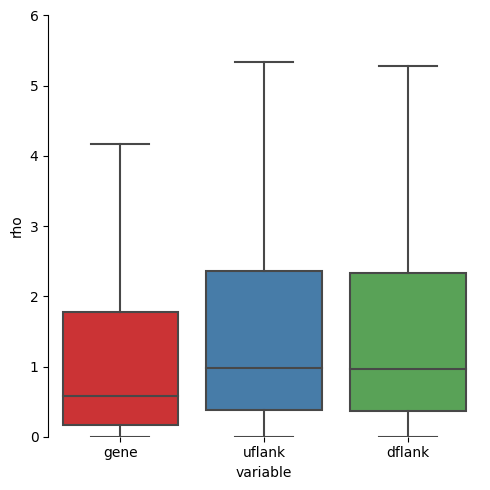

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')

ax.set_ylim(0,6)

plt.tight_layout()
sns.despine(bottom=True)
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

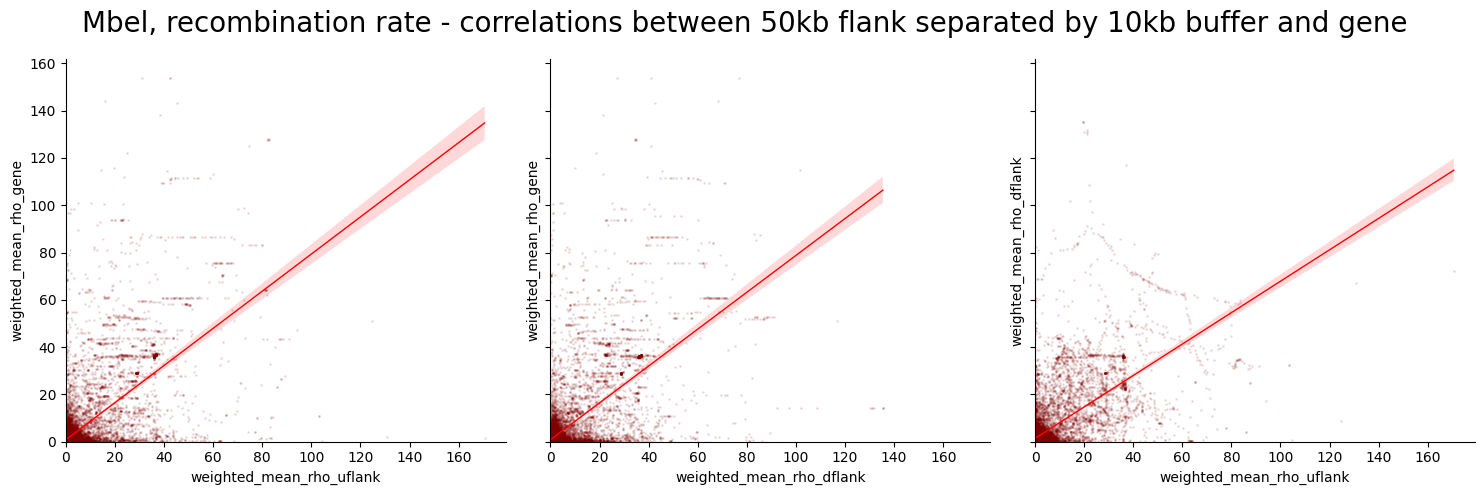

In [32]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

ax.set_xlim(0,)
ax.set_ylim(0,)

fig.suptitle("Mbel, recombination rate - correlations between 50kb flank separated by 10kb buffer and gene", size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_correlations_between_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_correlations_between_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')

plt.show()

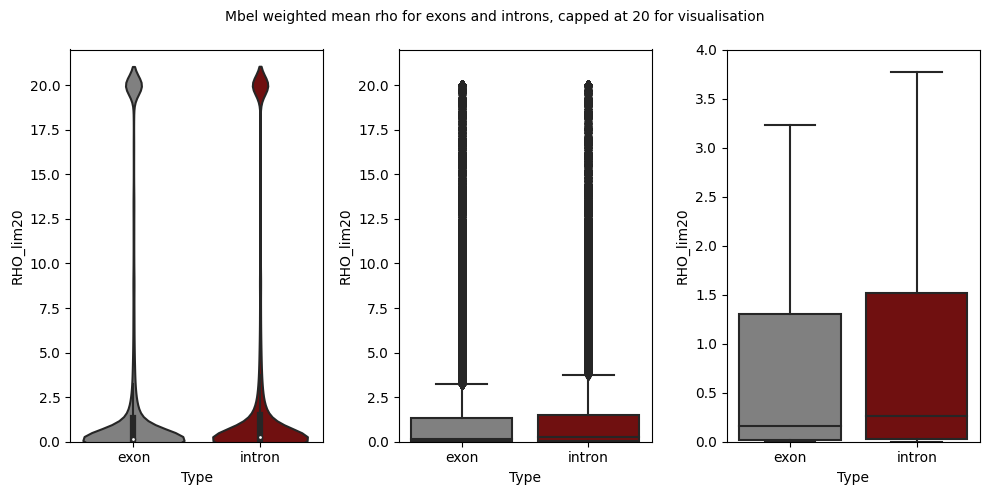

In [45]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,22)
ax1.set_ylim(0,22)
fig.suptitle('Mbel weighted mean rho for exons and introns, capped at 20 for visualisation', size=10)
ax2.set_ylim(0,4)
plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_and_alternatives_exon_and_introns.svg',bbox_inches='tight')
plt.show()

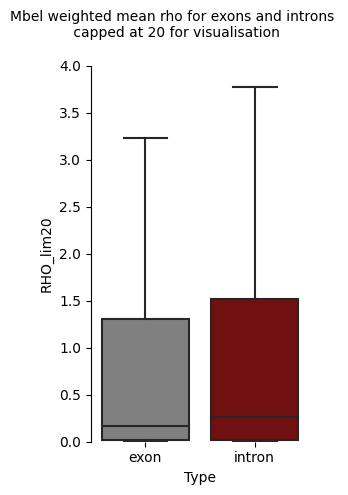

In [48]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,5), sharey=False)


sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,4)

fig.suptitle('Mbel weighted mean rho for exons and introns \n capped at 20 for visualisation', size=10)

plt.tight_layout()
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outliers_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_boxplot_no_outliers_exon_and_introns.svg',bbox_inches='tight')
sns.despine(bottom=True)
plt.show()

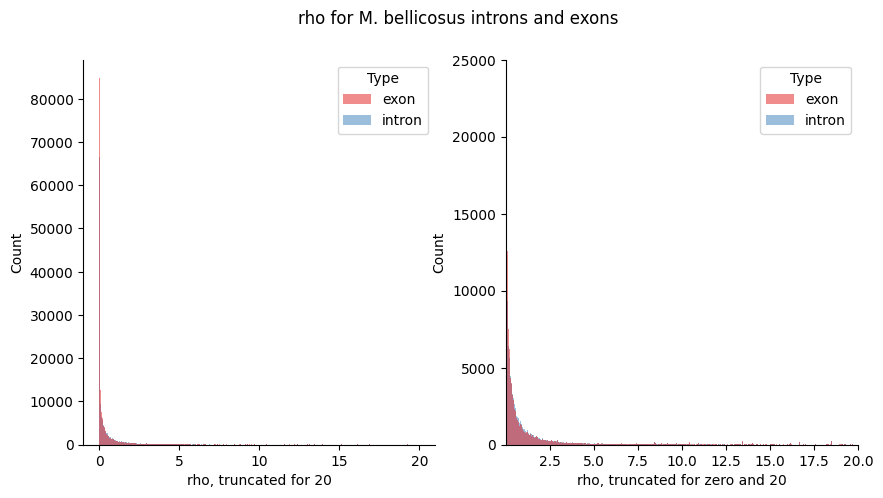

In [53]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for M. bellicosus introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,20)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

plt.savefig('./figures/20230810_Mbel_rho_dist_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_dist_exon_and_introns.svg',bbox_inches='tight')
sns.despine()
plt.show()

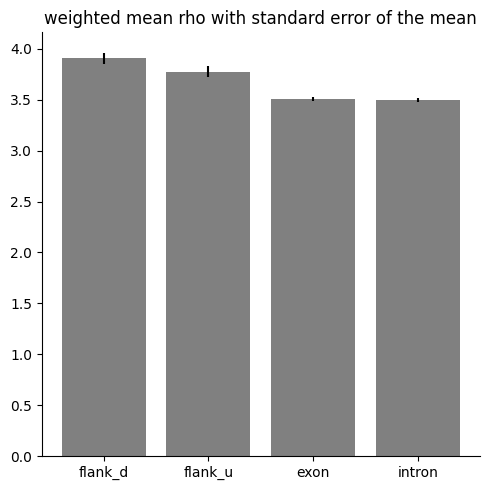

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [3.909249,3.777496,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.054706,0.053719,0.021512,0.022177], color='grey')
#ax1.bar(height = [3.909249,3.909249,3.508157,3.498127 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [11.521898,11.547933,10.836931,10.512917], color='grey')

ax.set_title("weighted mean rho with standard error of the mean")
#ax1.set_title("weighted mean rho with standard deviation")
sns.despine()
plt.tight_layout()
ax.set_ylim(0,)
plt.savefig('./figures/20230810_Mbel_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.svg',bbox_inches='tight')

plt.show()

In [58]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='intron']['RHO'].dropna()

thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.028     0.989    -0.197     0.253
 (0 - 2)      0.401     0.000     0.233     0.569
 (0 - 3)      0.411     0.000     0.242     0.580
 (1 - 0)     -0.028     0.989    -0.253     0.197
 (1 - 2)      0.373     0.000     0.205     0.541
 (1 - 3)      0.383     0.000     0.214     0.552
 (2 - 0)     -0.401     0.000    -0.569    -0.233
 (2 - 1)     -0.373     0.000    -0.541    -0.205
 (2 - 3)      0.010     0.988    -0.068     0.088
 (3 - 0)     -0.411     0.000    -0.580    -0.242
 (3 - 1)     -0.383     0.000    -0.552    -0.214
 (3 - 2)     -0.010     0.988    -0.088     0.068



# Csec - Rho

## load data

In [24]:
#load data
rho_chunks_df= pd.read_csv('./Csec/20230810_Csec_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t')
rho_chunks_dfmelt = rho_chunks_df.melt(id_vars=['idstring', 'scaffold'], value_vars=['weighted_mean_rho_gene', 'weighted_mean_rho_uflank', 'weighted_mean_rho_dflank',] )

rho_chunks_exin_df= pd.read_csv('./Csec/rho_per_gene/20230717_Csec_rho_exons_and_introns.tsv', sep='\t', index_col=0)
rho_chunks_exin_df.columns =['scaffold', 'source', 'Type', 'start', 'stop', 'n', 'strand', 'n2',
       'idstring', 'scaffold2', 'RHO']
rho_chunks_exin_df.RHO = rho_chunks_exin_df.RHO.replace('no_overlap_bin', np.nan).astype(float)

## plot

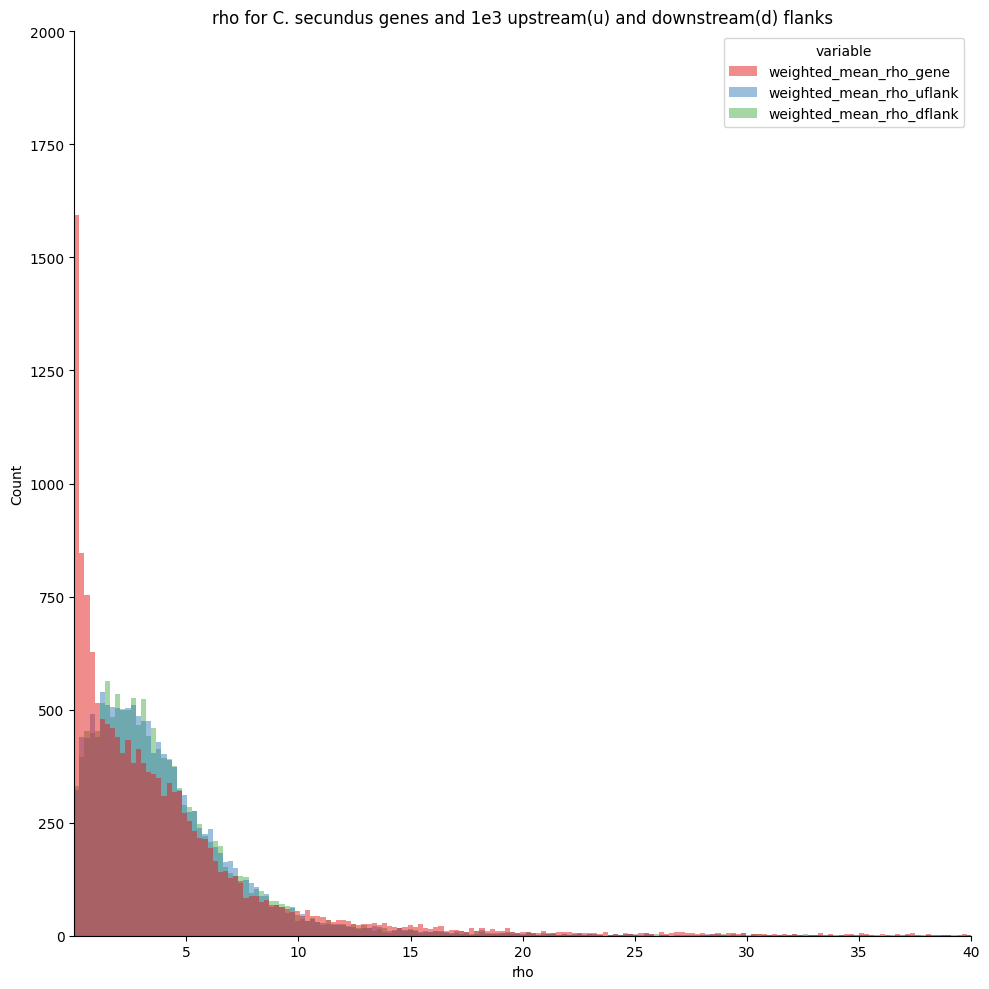

In [97]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=rho_chunks_dfmelt, x="value", hue="variable",linewidth=0, palette = ['#e41a1c','#377eb8','#4daf4a'])

ax.set_xlim(0.01,40)
ax.set_ylim(0.00,2000)
ax.set_title('rho for C. secundus genes and 1e3 upstream(u) and downstream(d) flanks')
ax.set_xlabel('rho')

sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_dist_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_dist_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

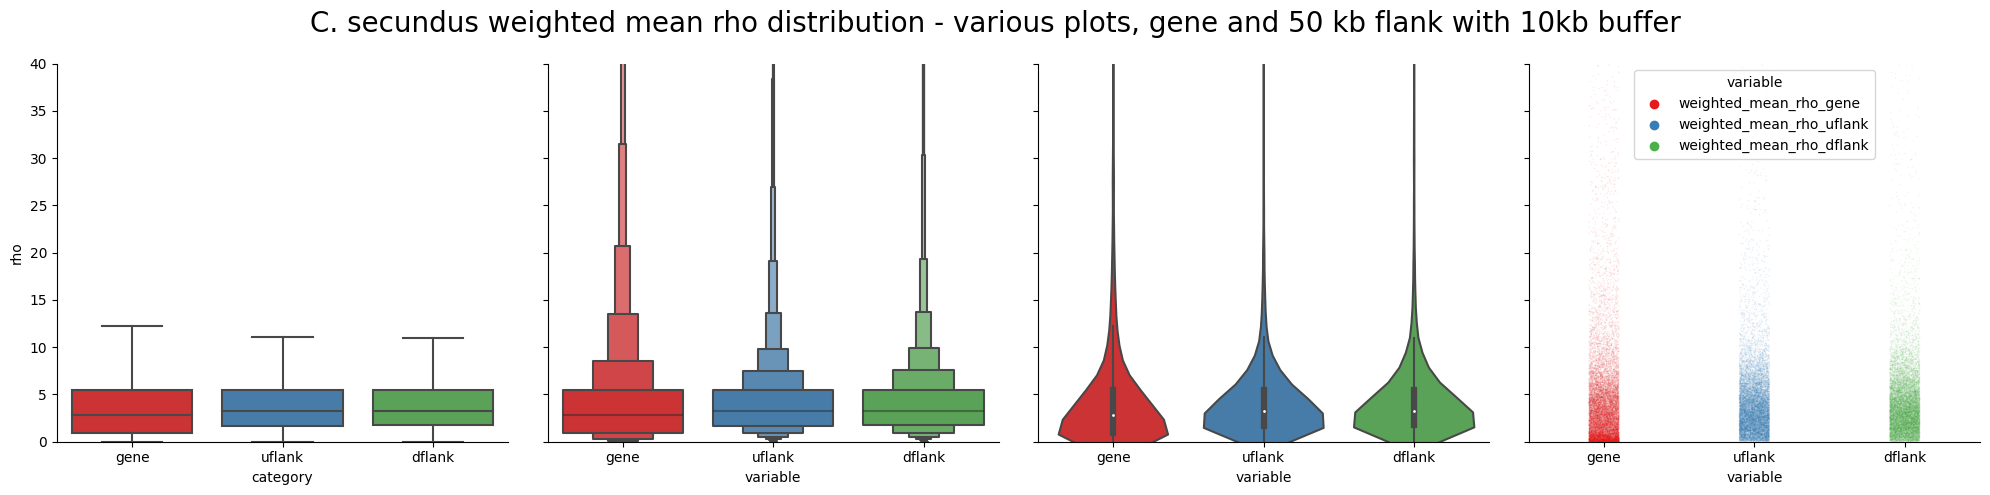

In [98]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=rho_chunks_dfmelt, y="value",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
ax1.set_ylabel(' ')
ax2.set_ylabel(' ')
ax3.set_ylabel(' ')
ax.set_xlabel('category')
ax.set_ylim(0,40)

fig.suptitle('C. secundus weighted mean rho distribution - various plots, gene and 50 kb flank with 10kb buffer', size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

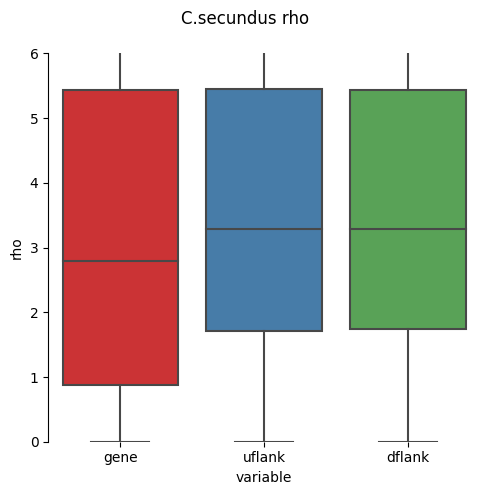

In [100]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
sns.boxplot(data=rho_chunks_dfmelt, y="value",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)


ax.set_xticklabels(['gene', 'uflank', 'dflank'])
ax.set_ylabel('rho')
fig.suptitle('C.secundus rho')
ax.set_ylim(0,6)

plt.tight_layout()
sns.despine(bottom=True)
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outlier_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')
plt.show()

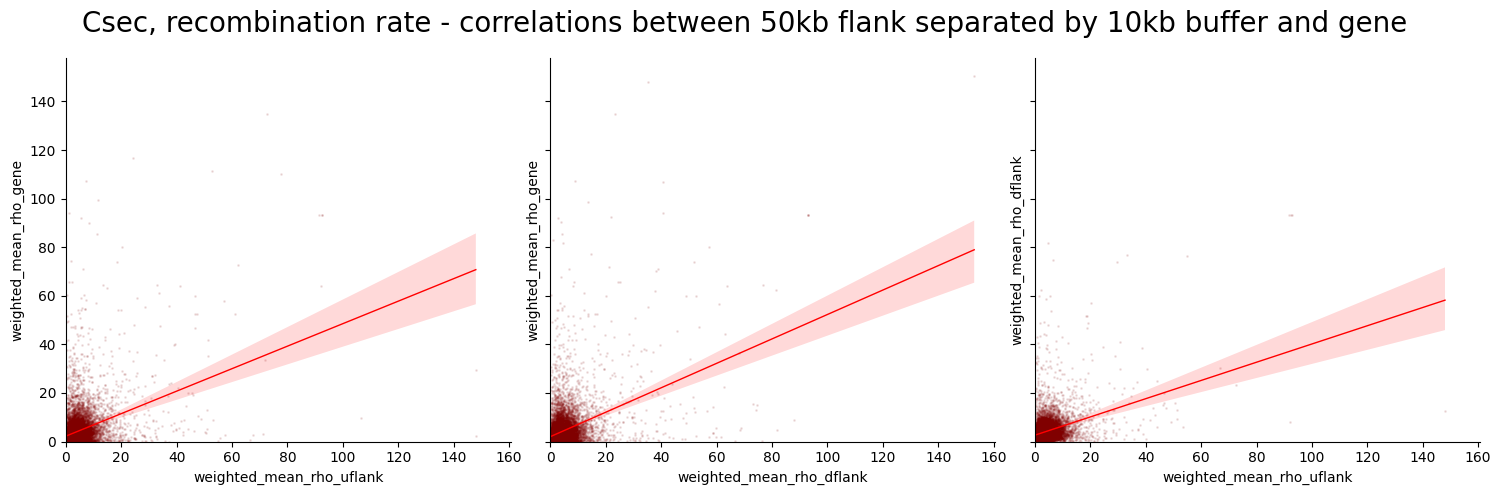

In [101]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_gene", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_dflank", y="weighted_mean_rho_gene", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=rho_chunks_df, x="weighted_mean_rho_uflank", y="weighted_mean_rho_dflank", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

ax.set_xlim(0,)
ax.set_ylim(0,)

fig.suptitle("Csec, recombination rate - correlations between 50kb flank separated by 10kb buffer and gene", size=20)
sns.despine()
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_correlations_between_gene_and_flanks50kb_buffer10kb.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_correlations_between_gene_and_flanks50kb_buffer10kb.svg',bbox_inches='tight')

plt.show()

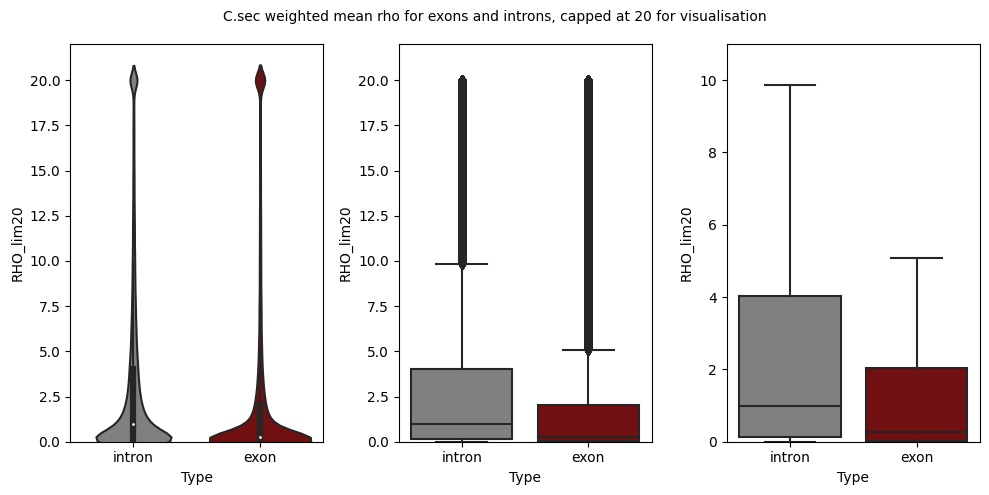

In [106]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5), sharey=False)

sns.violinplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,22)
ax1.set_ylim(0,22)
fig.suptitle('C.sec weighted mean rho for exons and introns, capped at 20 for visualisation', size=10)
ax2.set_ylim(0,11)
plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_and_alternatives_exon_and_introns.svg',bbox_inches='tight')
plt.show()

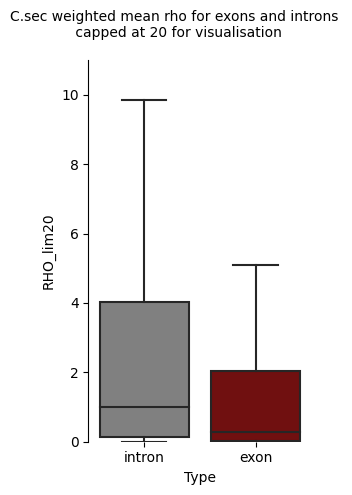

In [107]:
rho_chunks_exin_df['RHO_lim20']  = [i if i<20 else 20 for i in rho_chunks_exin_df['RHO']]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,5), sharey=False)

sns.boxplot(data=rho_chunks_exin_df, x='Type', y='RHO_lim20', ax=ax, fliersize=0,palette=['grey', 'maroon'])

ax.set_ylim(0,11)

fig.suptitle('C.sec weighted mean rho for exons and introns \n capped at 20 for visualisation', size=10)

plt.tight_layout()
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outliers_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_boxplot_no_outliers_exon_and_introns.svg',bbox_inches='tight')
sns.despine(bottom=True)
plt.show()

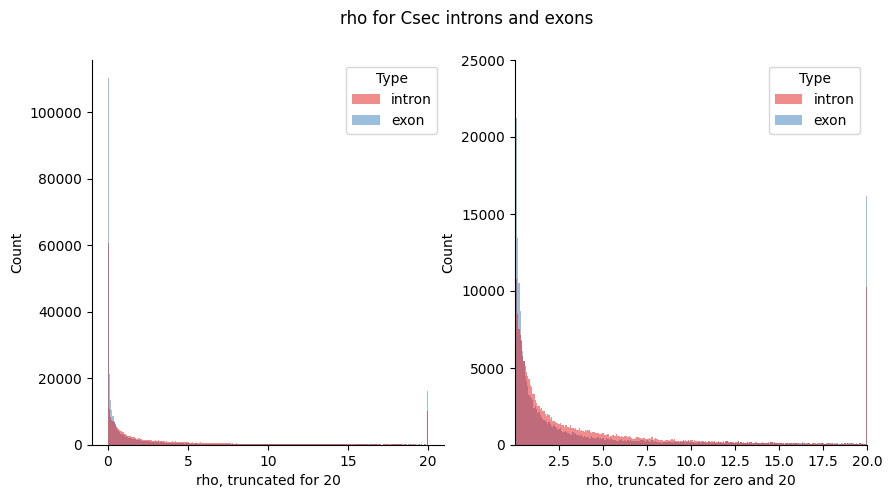

In [108]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('rho for Csec introns and exons')
ax.set_xlabel('rho, truncated for 20')

sns.histplot(data=rho_chunks_exin_df, x="RHO_lim20", hue="Type",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,20)
ax1.set_ylim(0,25000)
ax1.set_xlabel('rho, truncated for zero and 20')

plt.savefig('./figures/20230810_Csec_rho_dist_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_dist_exon_and_introns.svg',bbox_inches='tight')
sns.despine()
plt.show()

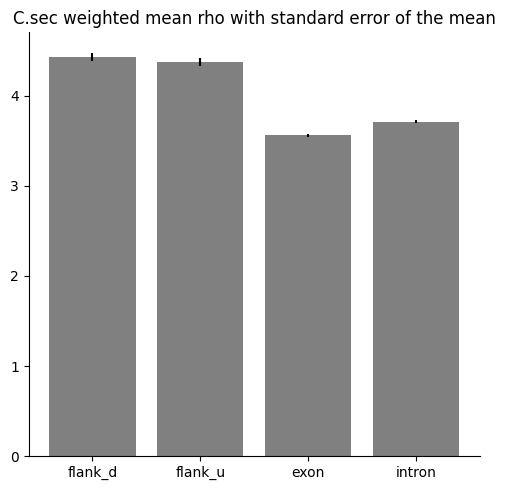

In [189]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [4.432077,4.373883, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.046994,0.045769,0.017638,0.014387], color='grey')
#ax1.bar(height = [4.457875,4.463503, 3.558582,3.711299 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [9.954115,10.160580,9.801586,7.556328], color='grey')

ax.set_title("C.sec weighted mean rho with standard error of the mean")

sns.despine()
plt.tight_layout()
ax.set_ylim(0,)

plt.savefig('./figures/20230810_Csec_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Csec_rho_barplot_with_sem_50kb_flank_10kbbuffer_and_exon_and_introns.svg',bbox_inches='tight')

plt.show()

In [113]:
fd = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_dflank' ]['value'].dropna()
fu = rho_chunks_dfmelt.loc[rho_chunks_dfmelt.variable =='weighted_mean_rho_uflank' ]['value'].dropna()
ex = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='exon']['RHO'].dropna()
intr = rho_chunks_exin_df.loc[rho_chunks_exin_df.Type =='intron']['RHO'].dropna()

thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.058     0.945    -0.212     0.328
 (0 - 2)      0.873     0.000     0.679     1.068
 (0 - 3)      0.721     0.000     0.525     0.916
 (1 - 0)     -0.058     0.945    -0.328     0.212
 (1 - 2)      0.815     0.000     0.620     1.010
 (1 - 3)      0.663     0.000     0.467     0.858
 (2 - 0)     -0.873     0.000    -1.068    -0.679
 (2 - 1)     -0.815     0.000    -1.010    -0.620
 (2 - 3)     -0.153     0.000    -0.211    -0.094
 (3 - 0)     -0.721     0.000    -0.916    -0.525
 (3 - 1)     -0.663     0.000    -0.858    -0.467
 (3 - 2)      0.153     0.000     0.094     0.211



# Mbel-CpG

# Csec-CpG

In [23]:
Csec_CpG_gene_and_flank = pd.read_csv( './Csec/20230810_Csec_CpG_per_gene_and_50kbflank_10kbbuffer.tsv', sep='\t', index_col=0)
Csec_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Csec/20230717_Csec_CpG_exons_and_introns.tsv', sep='\t', index_col=0)

In [37]:
rho_chunks_exin_df

,scaffold,source,Type,start,stop,n,strand,n2,idstring,scaffold2,RHO
0,,,,,,,,,,,
511495,NW_019731994.1,.,intron,416800,421167,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,5.475161
511496,NW_019731994.1,Gnomon,exon,421168,421270,.,+,.,ID=exon-XM_023857401.2-9;Parent=rna-XM_0238574...,NEVH01013973.1,3.832550
511498,NW_019731994.1,.,intron,421271,422203,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,1.480505
511499,NW_019731994.1,Gnomon,exon,422204,422499,.,+,.,ID=exon-XM_023857401.2-10;Parent=rna-XM_023857...,NEVH01013973.1,3.815746
511501,NW_019731994.1,.,intron,422500,423379,.,+,.,Parent=rna-XM_023857401.2,NEVH01013973.1,8.133196
...,...,...,...,...,...,...,...,...,...,...,...
768548,NW_019739943.1,Gnomon,exon,1063378,1063551,.,-,.,ID=exon-XM_033754500.1-14;Parent=rna-XM_033754...,NEVH01021922.1,14.823760
768550,NW_019739943.1,.,intron,1063552,1082684,.,-,.,Parent=rna-XM_033754500.1,NEVH01021922.1,5.716653
768551,NW_019739943.1,Gnomon,exon,1082685,1082816,.,-,.,ID=exon-XM_033754500.1-13;Parent=rna-XM_033754...,NEVH01021922.1,38.055080


In [39]:
Csec_exin = pd.merge(left=Csec_CpG_exon_and_intron, right=rho_chunks_exin_df, left_on=['ID','featuretype'], right_on=['idstring','Type'])

In [40]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [41]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [25]:
Csec_gene_and_flank = pd.merge(left=rho_chunks_df, right=Csec_CpG_gene_and_flank, left_on='idstring', right_on='ID')

In [42]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [46]:
Csec_exin.ID[0]

'ID=exon-XM_023864154.2-6;Parent=rna-XM_023864154.2;Dbxref=GeneID:111871218,Genbank:XM_023864154.2;gbkey=mRNA;gene=LOC111871218;product=uncharacterized LOC111871218%2C transcript variant X1;transcript_id=XM_023864154.2'

In [52]:
DE_data.Csec_geneName

0       Csec_G08529
1       Csec_G08558
2       Csec_G10175
3       Csec_G10405
4       Csec_G10411
           ...     
1806    Csec_G05159
1807    Csec_G05306
1808    Csec_G05317
1809    Csec_G06487
1810    Csec_G07846
Name: Csec_geneName, Length: 1811, dtype: object

In [59]:
[ str(i) for i in DE_data.Csec_geneName if str(i).startswith('Csec_G')]

['Csec_G08529',
 'Csec_G08558',
 'Csec_G10175',
 'Csec_G10405',
 'Csec_G10411',
 'Csec_G11924',
 'Csec_G11926',
 'Csec_G12414',
 'Csec_G12415',
 'Csec_G12693',
 'Csec_G12695',
 'Csec_G12698',
 'Csec_G14806',
 'Csec_G14807',
 'Csec_G15120',
 'Csec_G16260',
 'Csec_G16265',
 'Csec_G08751',
 'Csec_G17387',
 'Csec_G18162',
 'Csec_G18346',
 'Csec_G01621',
 'Csec_G01622',
 'Csec_G01623',
 'Csec_G08756',
 'Csec_G03370',
 'Csec_G03390',
 'Csec_G04781',
 'Csec_G04784',
 'Csec_G06821',
 'Csec_G06830',
 'Csec_G09368',
 'Csec_G10723',
 'Csec_G11359',
 'Csec_G11360',
 'Csec_G13267',
 'Csec_G13971',
 'Csec_G14850',
 'Csec_G16611',
 'Csec_G17079',
 'Csec_G17718',
 'Csec_G01756',
 'Csec_G01764',
 'Csec_G10951',
 'Csec_G02647',
 'Csec_G02654',
 'Csec_G02656',
 'Csec_G02661',
 'Csec_G02662',
 'Csec_G02668',
 'Csec_G02675',
 'Csec_G02676',
 'Csec_G02677',
 'Csec_G10956',
 'Csec_G03702',
 'Csec_G03708',
 'Csec_G03709',
 'Csec_G04375',
 'Csec_G04377',
 'Csec_G04382',
 'Csec_G04384',
 'Csec_G00910',
 'Csec_G

In [5]:
# generating the intron positions with Genometools has left the IDstring somewhat sparse, only denoting parent RNA.
# here i use the richer ID-string of the exons to link parent-RNA to the genebank ID

ID_dict = {}
for i in Csec_exin.loc[Csec_exin.featuretype=='exon'].ID:
    idfields = i.split(';')
    idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
    ID_dict[idict['Parent']] = idict['Dbxref']


def extract_id(idstring, idtype = 'Dbxref', ID_dict=False):
    if ID_dict == False:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        return idict[idtype].split(',')[0]
    else:
        idfields = idstring.split(';')
        idict = {i.split('=')[0]:i.split('=')[1] for i in idfields}
        try:
            return idict[idtype].split(',')[0]
        except KeyError:
            return ID_dict[idict['Parent']].split(',')[0]
            

In [6]:
Csec_gene_and_flank['GeneID'] = [extract_id(i) for i in Csec_gene_and_flank.ID]

In [7]:
Csec_exin['GeneID'] = [extract_id(i, ID_dict=ID_dict) for i in Csec_exin.ID]

In [8]:
# remnove superfluous columns
Csec_gene_and_flank = Csec_gene_and_flank[['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID', 'gene_cpg_e',
       'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o',
       'flank_u_cpg_oe', 'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe',
       'GeneID']]

In [9]:
# rename scaffold and rho columns to avoid issues down the line
Csec_exin.columns = ['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe',
       'scaffold2', 'source', 'start', 'stop', 'n', 'strand', 'n2',
       'scaffold', 'weighted_mean_rho_gene', 'GeneID']

In [10]:
# remnove superfluous columns
Csec_exin = Csec_exin[['featuretype', 'ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe','source', 'start', 'stop', 'n', 'strand', 'n2','scaffold', 'weighted_mean_rho_gene', 'GeneID']]

In [11]:
merged_Csec = pd.concat([Csec_gene_and_flank, Csec_exin])

In [12]:
#merged_Csec.to_csv('./20230727_Csec_rho_and_CpG_for_genes_flanking1e3_and_exons_introns.tsv', sep='\t')

# Mbel-DE

In [121]:

#Mbel
        #rho
Mbel_rho_gene_and_flank = rho_chunks_df = pd.read_csv('./Mbel/20230810_Mbel_rho_per_gene_and_50kbflank_with_10kbbuffer.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron =  pd.read_csv('./Mbel/20230717_Mbel_rho_exons_and_introns.tsv', sep='\t', index_col=0)
Mbel_rho_exon_and_intron.RHO = Mbel_rho_exon_and_intron.RHO.replace('no_overlap_bin', np.nan).astype(float)
        #CpG
Mbel_CpG_gene_and_flank = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t',index_col=0)
Mbel_CpG_exon_and_intron = pd.read_csv('/proj/snic2021-23-365/private/TR_20230707/TR_20230707_per_gene_analysis/Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t',index_col=0)


In [122]:
Mbel_rho_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'ID']
Mbel_gene_and_flank = pd.merge(left=Mbel_rho_gene_and_flank, right=Mbel_CpG_gene_and_flank, left_on='ID', right_on='ID')
Mbel_exin = pd.merge(left=Mbel_CpG_exon_and_intron, right=Mbel_rho_exon_and_intron, left_on=['ID'], right_on=['ID'])

In [123]:
Mbel_exin

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,Scaffold,Type,Start_pos,End_pos,gene_id,RHO
0,g22731.t1.intron6,21.374046,0,0.000000,scaffold6,intron,27962678,27963464,g22731.t1,0.098135
1,g22731.t1.exon7,16.271186,6,0.368750,scaffold6,exon,27963465,27963760,g22731.t1,0.101440
2,g22731.t1.intron7,37.698344,5,0.132632,scaffold6,intron,27963761,27964908,g22731.t1,0.231845
3,g22731.t1.exon8,17.885350,6,0.335470,scaffold6,exon,27964909,27965223,g22731.t1,0.308049
4,g22731.t1.intron8,7.959302,2,0.251278,scaffold6,intron,27965224,27965568,g22731.t1,0.221740
...,...,...,...,...,...,...,...,...,...,...
500942,g10458.t1.exon2,5.008696,1,0.199653,scaffold62,exon,4364503,4364618,g10458.t1,NaN
500943,g10458.t1.intron2,87.118243,50,0.573933,scaffold62,intron,4364619,4366987,g10458.t1,NaN
500944,g10458.t1.exon3,8.888889,6,0.675000,scaffold62,exon,4366988,4367168,g10458.t1,NaN
500945,g10458.t1.intron3,58.456164,18,0.307923,scaffold62,intron,4367169,4368629,g10458.t1,NaN


In [124]:
Mbel_exin.columns = ['ID', 'gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'scaffold', 'featuretype',
       'Start_pos', 'End_pos', 'GeneID', 'weighted_mean_rho_gene']

In [125]:
Mbel_gene_and_flank.columns = ['scaffold', 'weighted_mean_rho_gene', 'weighted_mean_rho_uflank',
       'weighted_mean_rho_dflank', 'GeneID', 'gene_cpg_e', 'gene_cpg_o',
       'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o', 'flank_u_cpg_oe',
       'flank_d_cpg_e', 'flank_d_cpg_o', 'flank_d_cpg_oe']

In [126]:
merged_Mbel = pd.concat([Mbel_exin,Mbel_gene_and_flank])
merged_Mbel.featuretype = merged_Mbel.featuretype.replace(np.nan, 'gene')

In [25]:
DEdf = pd.read_csv('./Mbel/20230727_DE_table_with_orthologues_from_elsner2017.tsv', sep='\t', index_col=0)
DEdf = DEdf.dropna(subset=['sgo'])
DEdf.columns = ['GeneID_Mnat', 'DE', 'DE_royal', 'sgo', 'sgo_mbel', 'sgo_mnat',
       'king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       'orthologues']
DE_sgo = DEdf.loc[DEdf.sgo==True]
DE_Mbel = merged_Mbel.merge(DE_sgo, left_on='GeneID', right_on='orthologues')
DE_Mbel = DE_Mbel.replace('no_overlap_bin', np.nan)
DE_Mbel.weighted_mean_rho_gene = DE_Mbel.weighted_mean_rho_gene.astype(float)

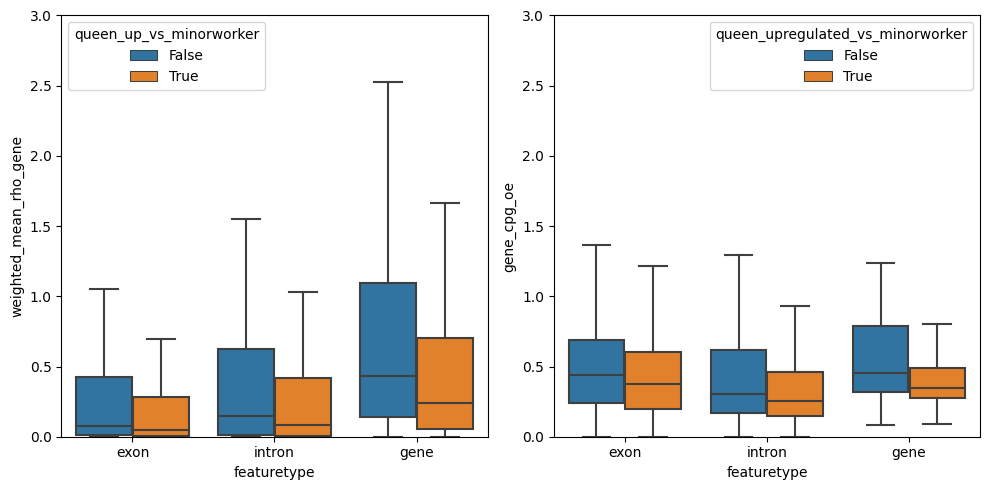

In [129]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax) 

sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue='queen_upregulated_vs_minorworker', dodge=True, fliersize=0, ax=ax1) 

ax.set_ylim(0,3)
ax1.set_ylim(0,3)
ax.legend(title='queen_up_vs_minorworker', loc='upper left')

plt.tight_layout()
plt.show()

In [134]:
DEtypes = ['DE', 'DE_royal','king_upregulated_vs_queen', 'majorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_queen', 'queen_upregulated_vs_king',
       'queen_upregulated_vs_majorworker', 'king_upregulated_vs_majorworker',
       'minorworker_upregulated_vs_majorworker',
       'king_upregulated_vs_minorworker', 'minorworker_upregulated_vs_king',
       'majorworker_upregulated_vs_minorworker',
       'queen_upregulated_vs_minorworker', 'minorworker_upregulated_vs_queen',
       ]

In [31]:
flanks = merged_Mbel.loc[merged_Mbel.featuretype=='gene'][['GeneID', 'mean_rho_flank', 'mean_cpg_flank']]

In [33]:
merged_Mbel_flankall = pd.merge( left=merged_Mbel, right=flanks, left_on='GeneID', right_on='GeneID', how='left')

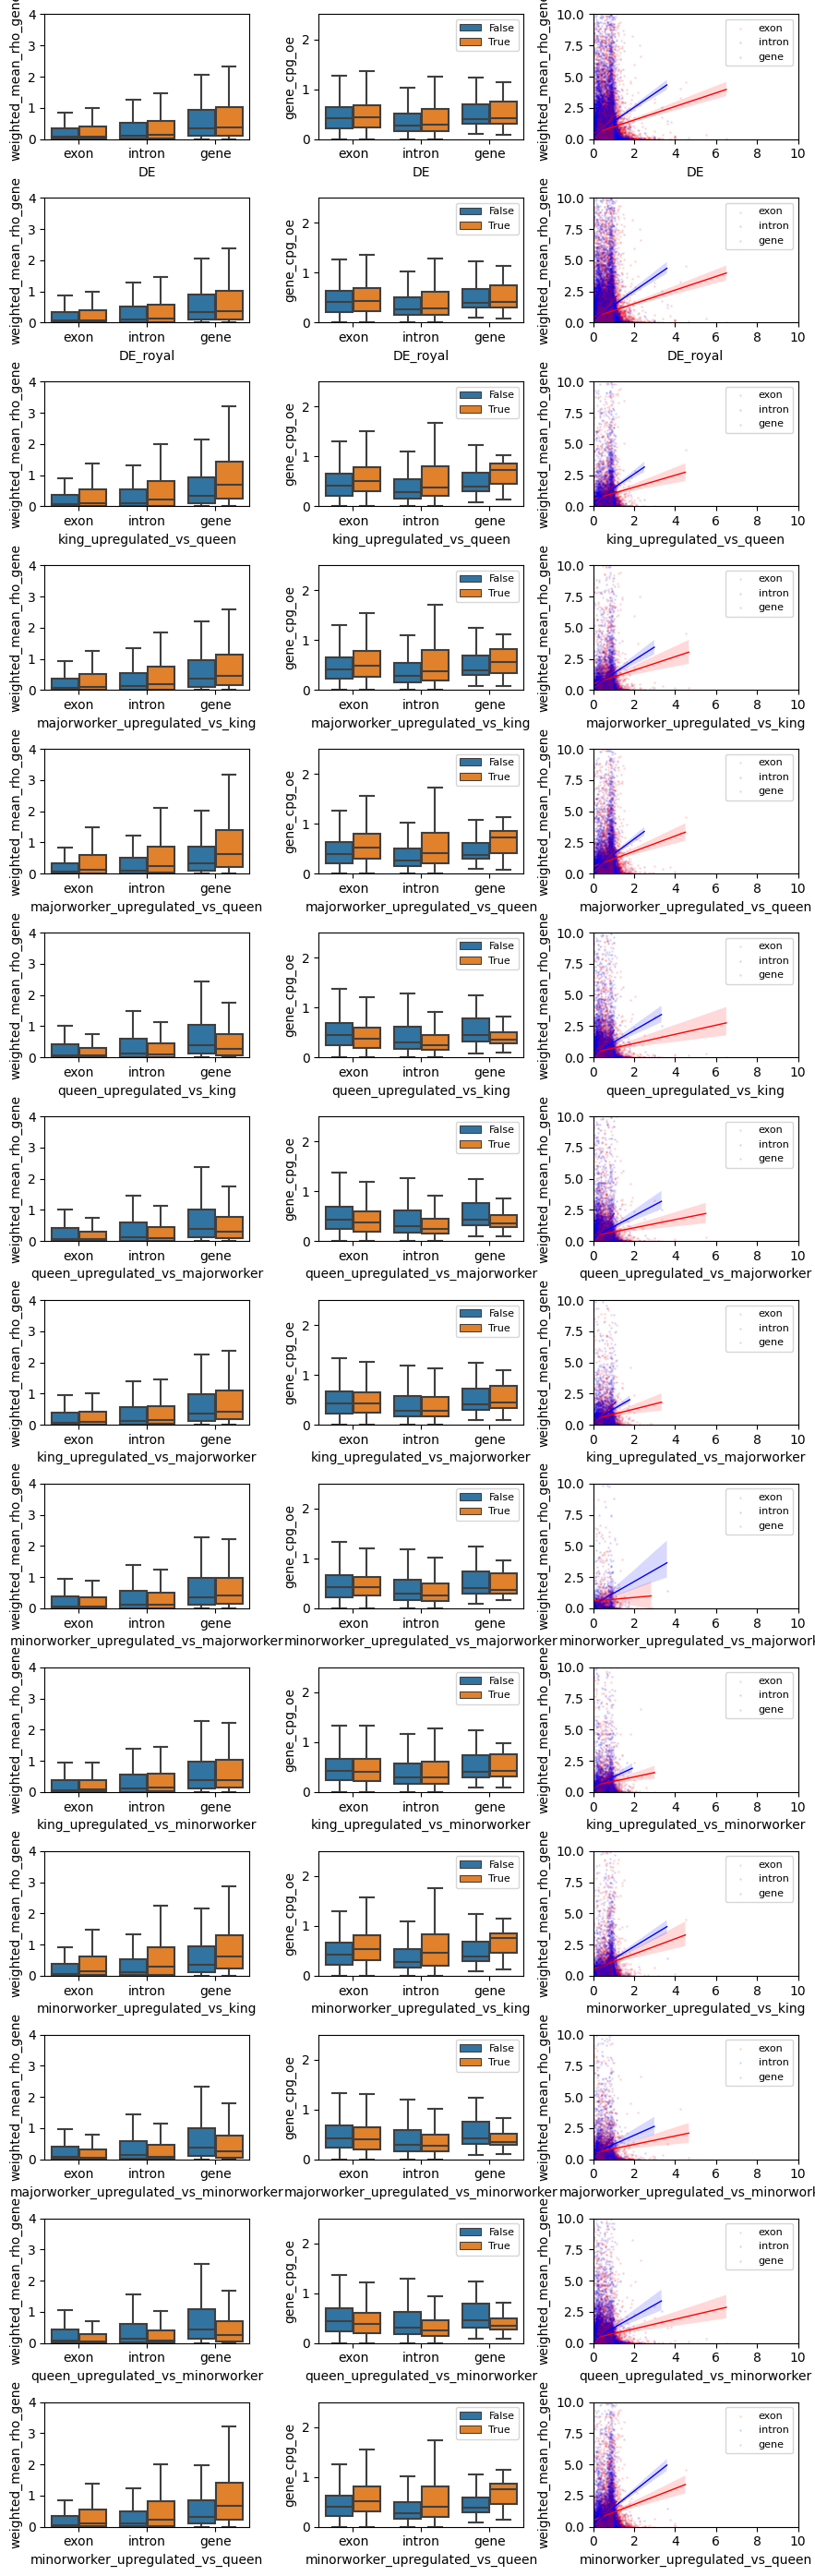

In [194]:
fig, axes = plt.subplots(ncols=3, nrows=14, figsize=(9, 28), sharex=False, sharey='col')
for i, k  in enumerate(DEtypes):
    sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='exon'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='intron'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron')
    sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='gene'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'purple', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'purple'}, label='gene')

    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,4)
    axes[i,1].set_ylim(0,2.5)
    axes[i,0].set_xlabel(k)
    axes[i,1].set_xlabel(k)
    axes[i,2].set_xlabel(k)
    axes[i,2].set_ylim(0,10)
    axes[i,2].set_xlim(0,10)
    axes[i,2].legend(fontsize=8)
plt.savefig('./figures/20230810_Mbel_DE_panel.png',bbox_inches='tight')
plt.savefig('./figures/20230810_Mbel_DE_panel.svg',bbox_inches='tight')
plt.tight_layout()
plt.show()

In [144]:
axes.shape

(14, 2)

In [168]:
DE_Mbel

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,scaffold,featuretype,Start_pos,End_pos,GeneID,weighted_mean_rho_gene,...,queen_upregulated_vs_king,queen_upregulated_vs_majorworker,king_upregulated_vs_majorworker,minorworker_upregulated_vs_majorworker,king_upregulated_vs_minorworker,minorworker_upregulated_vs_king,majorworker_upregulated_vs_minorworker,queen_upregulated_vs_minorworker,minorworker_upregulated_vs_queen,orthologues
0,g4861.t1.exon1,0.857143,0,0.000000,scaffold5,exon,17622247.0,17622261.0,g4861.t1,2.278240,...,True,True,False,False,True,False,True,True,False,g4861.t1
1,g4861.t1.intron1,125.690391,86,0.684221,scaffold5,intron,17622262.0,17625634.0,g4861.t1,1.652539,...,True,True,False,False,True,False,True,True,False,g4861.t1
2,g4861.t1.exon2,6.967742,1,0.143519,scaffold5,exon,17625635.0,17625790.0,g4861.t1,0.010810,...,True,True,False,False,True,False,True,True,False,g4861.t1
3,g4861.t1.intron2,38.965517,9,0.230973,scaffold5,intron,17625791.0,17626951.0,g4861.t1,0.008107,...,True,True,False,False,True,False,True,True,False,g4861.t1
4,g4861.t1.exon3,5.657143,1,0.176768,scaffold5,exon,17626952.0,17627057.0,g4861.t1,0.006560,...,True,True,False,False,True,False,True,True,False,g4861.t1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95160,g2881.t1.intron8,26.697303,6,0.224742,scaffold11,intron,28563531.0,28564532.0,g2881.t1,1.625669,...,False,False,False,False,False,False,False,False,False,g2881.t1
95161,g2881.t1.exon9,4.413043,0,0.000000,scaffold11,exon,28564533.0,28564625.0,g2881.t1,1.808020,...,False,False,False,False,False,False,False,False,False,g2881.t1
95162,g2881.t1.intron9,55.170732,18,0.326260,scaffold11,intron,28564626.0,28566676.0,g2881.t1,0.292779,...,False,False,False,False,False,False,False,False,False,g2881.t1
95163,g2881.t1.exon10,4.301205,3,0.697479,scaffold11,exon,28566677.0,28566760.0,g2881.t1,0.042660,...,False,False,False,False,False,False,False,False,False,g2881.t1


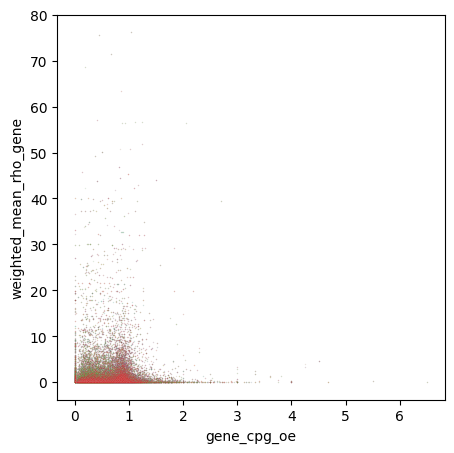

In [177]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharex=False, sharey='col')

for i, k  in enumerate(DEtypes):
    sns.scatterplot(data=DE_Mbel.loc[DE_Mbel[k]==True], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=ax, alpha=0.1, s=1)

In [ ]:
?sns.regplot

In [4]:
cpg_chunks_df = pd.read_csv('./Mbel/20230811_Mbel_CpG_per_gene_and_5okbflank_and_10kb_buffer_18batchmiss.tsv', sep='\t')
cpg_chunks_df_melt = cpg_chunks_df.melt(id_vars=['ID'], value_vars=['gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o','flank_u_cpg_oe','flank_d_cpg_e','flank_d_cpg_o','flank_d_cpg_oe'] )
cpg_chunks_df_melt_oe = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable.isin(['gene_cpg_oe', 'flank_u_cpg_oe', 'flank_d_cpg_oe'])]

In [19]:
cpg_chunks_exin_df = pd.read_csv('./Mbel/20230717_Mbel_CpG_exons_and_introns.tsv', sep='\t')
cpg_chunks_exin_df['gene_id'] = [i.rsplit('.',1)[0] for i in cpg_chunks_exin_df.ID]
cpg_chunks_exin_df['reg_id'] = [i.rsplit('.',1)[1] for i in cpg_chunks_exin_df.ID]
cpg_chunks_exin_df['reg_type'] = [''.join(i for i in st if i.isalpha()) for st in cpg_chunks_exin_df.reg_id]


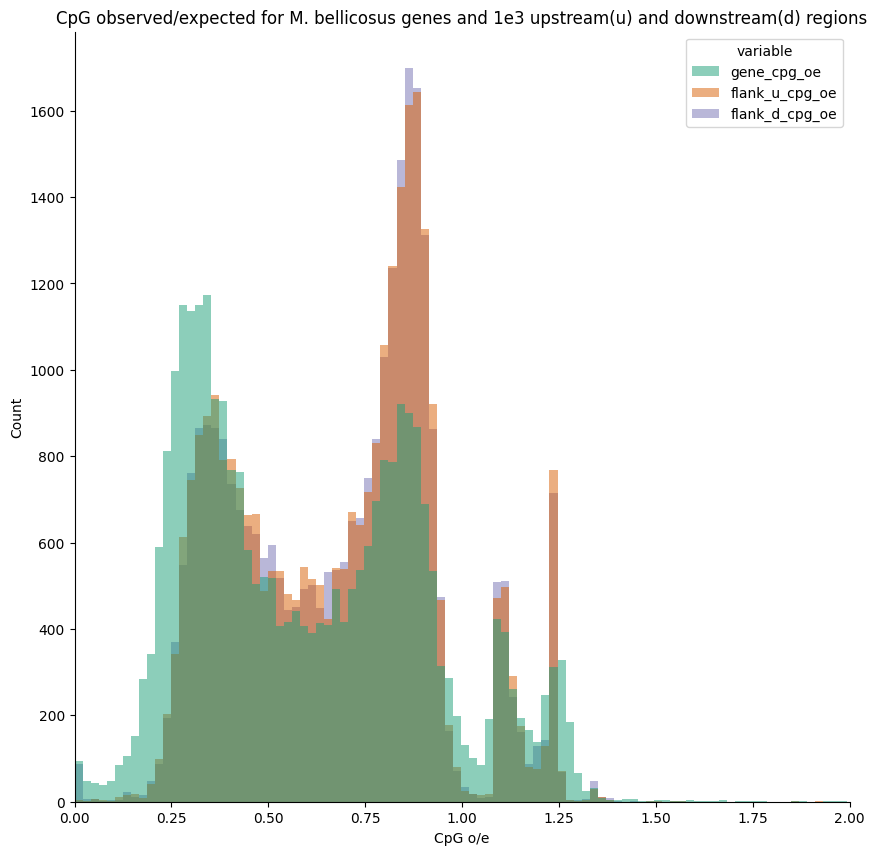

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=cpg_chunks_df_melt_oe, x="value", hue="variable",linewidth=0, palette = ['#1b9e77','#d95f02','#7570b3'])

ax.set_xlim(0,2)
ax.set_title('CpG observed/expected for M. bellicosus genes and 1e3 upstream(u) and downstream(d) regions')
ax.set_xlabel('CpG o/e')

sns.despine()
plt.show()


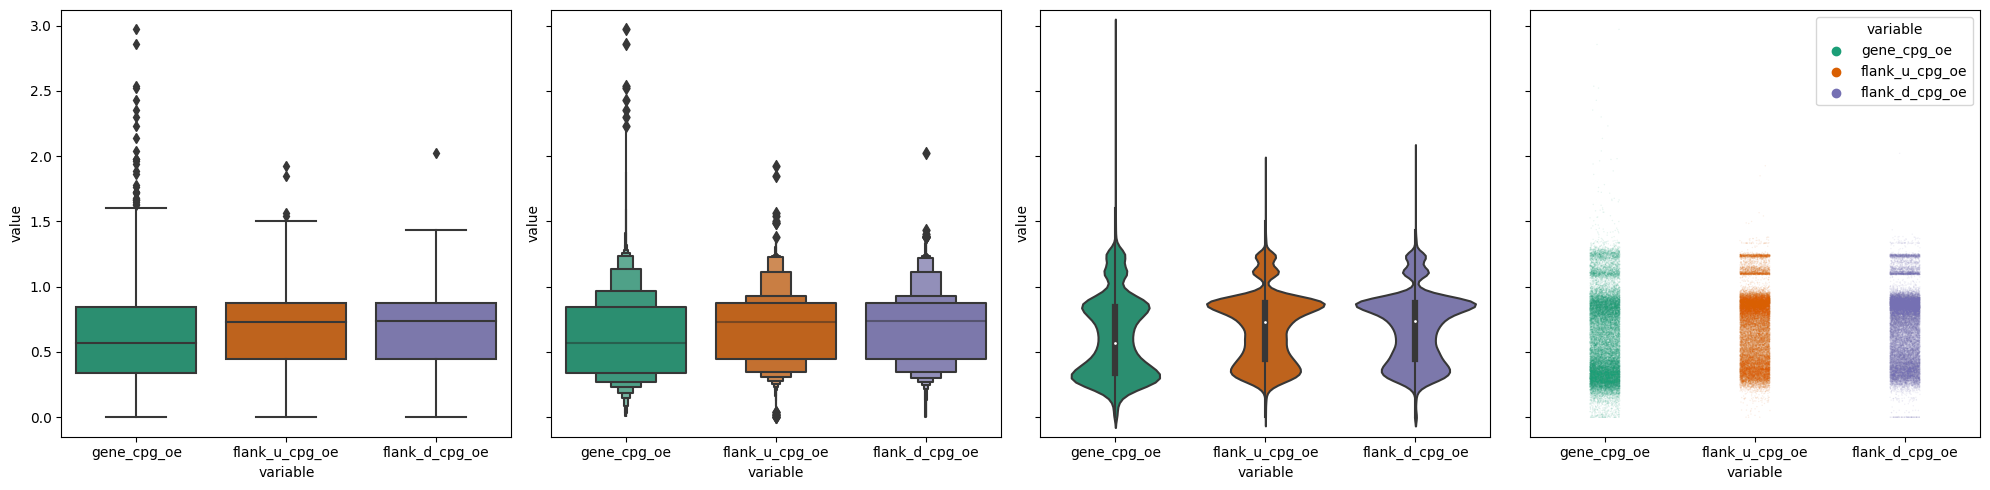

In [8]:
fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax)
sns.boxenplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax1)
sns.violinplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax2)
sns.stripplot(data=cpg_chunks_df_melt_oe, y="value",x='variable', hue='variable', palette = ['#1b9e77','#d95f02','#7570b3'], ax=ax3, alpha=0.1, s=1)

plt.tight_layout()
plt.show()

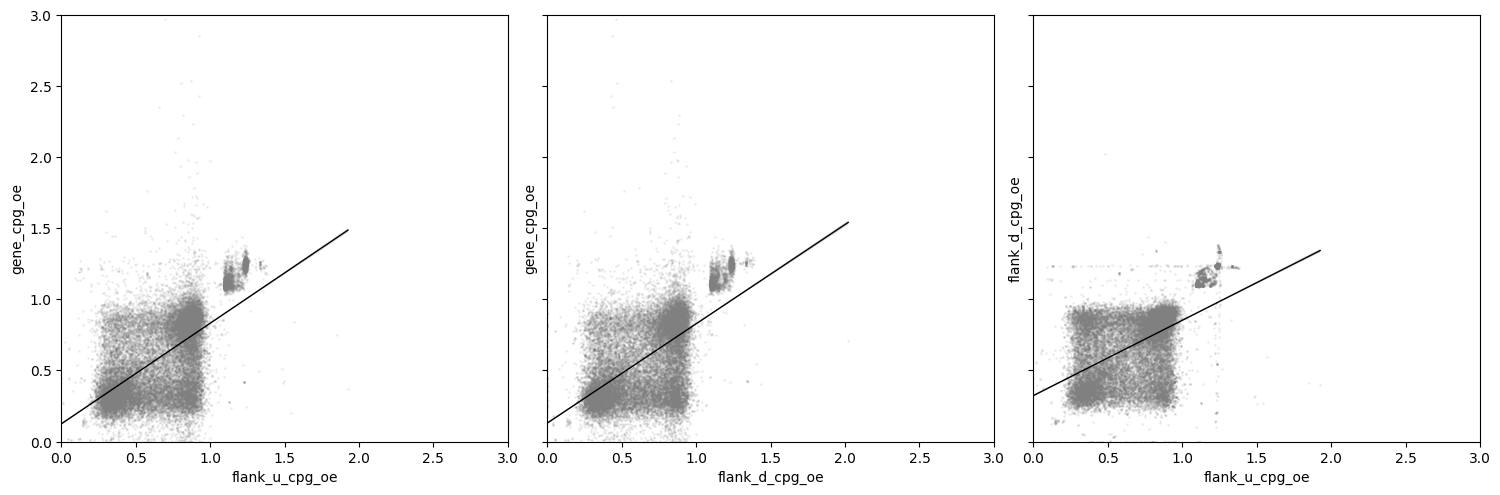

In [9]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="gene_cpg_oe", ax=ax, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_d_cpg_oe", y="gene_cpg_oe", ax=ax1, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )
sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="flank_d_cpg_oe", ax=ax2, line_kws={'color':'black', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'grey'} )

plt.tight_layout()
ax.set_ylim(0,3)
ax.set_xlim(0,3)

plt.show()

,Unnamed: 0,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,gene_id,reg_id
0,0,g22731.t1.intron6,21.374046,0,0.000000,g22731.t1,intron6
1,1,g22731.t1.CDS7,16.271186,6,0.368750,g22731.t1,CDS7
2,2,g22731.t1.exon7,16.271186,6,0.368750,g22731.t1,exon7
3,3,g22731.t1.intron7,37.698344,5,0.132632,g22731.t1,intron7
4,4,g22731.t1.CDS8,17.885350,6,0.335470,g22731.t1,CDS8
...,...,...,...,...,...,...,...
827904,4135,g10458.t1.CDS3,8.888889,6,0.675000,g10458.t1,CDS3
827905,4136,g10458.t1.exon3,8.888889,6,0.675000,g10458.t1,exon3
827906,4137,g10458.t1.intron3,58.456164,18,0.307923,g10458.t1,intron3
827907,4138,g10458.t1.CDS4,3.781818,2,0.528846,g10458.t1,CDS4


In [20]:
cpg_chunks_exin_df_onlyexin = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type.isin(['exon', 'intron'])]
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].mean()

reg_type
exon      0.564167
intron    0.482606
Name: gene_cpg_oe, dtype: float64

In [21]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].sem()

reg_type
exon      0.000850
intron    0.000768
Name: gene_cpg_oe, dtype: float64

In [22]:
cpg_chunks_exin_df_onlyexin.groupby('reg_type')['gene_cpg_oe'].std()

reg_type
exon      0.438275
intron    0.372242
Name: gene_cpg_oe, dtype: float64

In [23]:
cpg_chunks_df_melt.groupby('variable')['value'].mean()

variable
flank_d_cpg_e     2359.899680
flank_d_cpg_o     1832.578890
flank_d_cpg_oe       0.687312
flank_u_cpg_e     2517.649043
flank_u_cpg_o     1940.262923
flank_u_cpg_oe       0.686788
gene_cpg_e         955.367334
gene_cpg_o         558.520832
gene_cpg_oe          0.610369
Name: value, dtype: float64

In [24]:
cpg_chunks_df_melt.groupby('variable')['value'].sem()

variable
flank_d_cpg_e      7.265377
flank_d_cpg_o     10.336996
flank_d_cpg_oe     0.001529
flank_u_cpg_e     32.743299
flank_u_cpg_o     25.460435
flank_u_cpg_oe     0.001519
gene_cpg_e         7.809463
gene_cpg_o         5.355798
gene_cpg_oe        0.001800
Name: value, dtype: float64

In [25]:
cpg_chunks_df_melt.groupby('variable')['value'].std()

variable
flank_d_cpg_e     1248.334732
flank_d_cpg_o     1776.099347
flank_d_cpg_oe       0.262674
flank_u_cpg_e     5625.942935
flank_u_cpg_o     4374.603604
flank_u_cpg_oe       0.260958
gene_cpg_e        1341.819299
gene_cpg_o         920.231526
gene_cpg_oe          0.309197
Name: value, dtype: float64

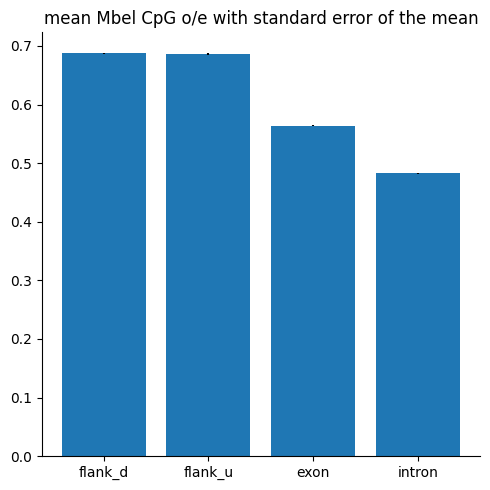

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
ax.bar(height = [0.687312,0.686788, 0.564167,0.482606 ], x=['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.001529,0.001519,0.000850,0.000768])
#ax1.bar(height = [0.670841,0.675701, 0.564167,0.482606 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.362396,0.362441,0.438275,0.372242])

ax.set_title("mean Mbel CpG o/e with standard error of the mean")
#ax1.set_title("mean CpG o/e with standard deviation")
sns.despine()
plt.tight_layout()
plt.show()

In [30]:
fd = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_d_cpg_oe' ]['value']
fu = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_u_cpg_oe' ]['value']
ex = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='exon']['gene_cpg_oe']
intr = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.reg_type =='intron']['gene_cpg_oe']

In [31]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [33]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.001     0.999    -0.008     0.009
 (0 - 2)      0.123     0.000     0.117     0.129
 (0 - 3)      0.205     0.000     0.198     0.211
 (1 - 0)     -0.001     0.999    -0.009     0.008
 (1 - 2)      0.123     0.000     0.116     0.129
 (1 - 3)      0.204     0.000     0.198     0.210
 (2 - 0)     -0.123     0.000    -0.129    -0.117
 (2 - 1)     -0.123     0.000    -0.129    -0.116
 (2 - 3)      0.082     0.000     0.079     0.084
 (3 - 0)     -0.205     0.000    -0.211    -0.198
 (3 - 1)     -0.204     0.000    -0.210    -0.198
 (3 - 2)     -0.082     0.000    -0.084    -0.079



# Csec - DE

In [21]:
DE_data = pd.read_csv('./Csec/DE_data/Queen_up_v_worker.tsv', comment='#', sep='\t')
DE_data.log2FoldChange = [ float(i.replace(',', '.')) for i in DE_data.log2FoldChange]
DE_data['worker_biased'] = DE_data.log2FoldChange>0
DE_data['queen_biased'] = DE_data.log2FoldChange<0

In [22]:
tdf = pd.read_csv('./Csec/DE_data/DE_ID_list.txt', sep='\t')

In [23]:
tdf

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17
0,105785,Cryptotermes secundus,111873815,0,live,Osi6,B7P43_G04590,Osiris 6,uncharacterized protein LOC111873815,NaN,Un,NW_019743150.1,73376.0,83284.0,minus,3.0,NaN,NaN
1,105785,Cryptotermes secundus,111863819,0,live,LOC111863819,"B7P43_G15667, hc2",hemocyanin,hemocyanin|hemocyanin subunit type 2,NaN,Un,NW_019718639.1,1620992.0,1642183.0,minus,11.0,NaN,NaN
2,105785,Cryptotermes secundus,111863773,0,live,LOC111863773,"B7P43_G15668, HCYA, hc1",hemocyanin A chain,hemocyanin A chain|hemocyanin subunit type 1,NaN,Un,NW_019718639.1,1648278.0,1665918.0,plus,10.0,NaN,NaN
3,105785,Cryptotermes secundus,111874735,0,live,LOC111874735,B7P43_G07079,esterase FE4,esterase FE4|female neotenic-specific protein 1,NaN,Un,NW_019744414.1,4483.0,27966.0,minus,10.0,NaN,NaN
4,105785,Cryptotermes secundus,111868690,0,live,LOC111868690,"B7P43_G14160, MYRO1_8",myrosinase 1,myrosinase 1|female neotenic-specific protein 2,NaN,Un,NW_019734331.1,764425.0,781973.0,minus,11.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15409,105785,Cryptotermes secundus,111861213,0,live,LOC111861213,NaN,cell division cycle 5-like protein,NaN,NaN,Un,NW_019718294.1,14433.0,18790.0,plus,0.0,NaN,NaN
15410,105785,Cryptotermes secundus,111861212,0,live,LOC111861212,"B7P43_G15958, Cbp53E",calbindin-32,calbindin-32,NaN,Un,NW_019721788.1,165740.0,545901.0,plus,13.0,NaN,NaN
15411,105785,Cryptotermes secundus,111861211,0,live,LOC111861211,"B7P43_G15962, DDX27_1",probable ATP-dependent RNA helicase DDX27,probable ATP-dependent RNA helicase DDX27|puta...,NaN,Un,NW_019721788.1,602289.0,658218.0,plus,14.0,NaN,NaN
15412,105785,Cryptotermes secundus,111861210,0,live,LOC111861210,B7P43_G00648,rho GTPase-activating protein 7,rho GTPase-activating protein 7,NaN,Un,NW_019718022.1,173878.0,348514.0,plus,20.0,NaN,NaN


In [24]:
tdict = {}
for i, k in tdf.iterrows():
    gid_old = str(k.Aliases).split(',')[0]
    if not gid_old  == 'nan':
        if gid_old.startswith('B7P43_'):
            gid_mod = 'Csec_'+gid_old.split('_')[1]
            tdict[gid_mod] = 'GeneID:'+str(k.GeneID)
        else:
            print(k.Aliases)

LTA4H_3
LTA4H_3
CYP6K1_11
CYP6K1_11, CYP6K1_6
RBL1_1
RBL1_1
DHRS11_9
DHRS11_9
DHRS11_9
DHRS11_9
Nif3l1_3
Nif3l1_3
CYP6J1_1
CYP6J1_1
UGT2B19_2
UGT2B19_2
Aldh1a2_2
Aldh1a2_2
UGT2B30_3
UGT2B30_3
UGT2B30_3, Ugt8
AKR1E2_1
AKR1E2_1
ESTF_15
Cg25C
Cg25C
SDR-1_5
SDR-1_5
SDR-1_5
Esd
Esd
Pak4_2
Pak4_2
PPP5C_1
PPP5C_1


In [50]:
#[i.split('_')[1] for i in DE_data.Csec_geneName]

In [25]:
gids_DE =[] 
for i, k in DE_data.iterrows():
    try:
        gids_DE.append(tdict[k.Csec_geneName])
    except KeyError:
        gids_DE.append(np.nan)
        
    

In [26]:
DE_data['GeneID'] = gids_DE

In [27]:
#[str(i).split(',')[0] for i in tdf.Aliases]

In [28]:
DE_data = DE_data.dropna(subset='GeneID')

In [29]:
DE_csec = merged_Csec.merge(right=DE_data, left_on='GeneID', right_on='GeneID')

In [30]:
merged_Csec

,scaffold,weighted_mean_rho_gene,weighted_mean_rho_uflank,weighted_mean_rho_dflank,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,flank_u_cpg_e,flank_u_cpg_o,...,GeneID,featuretype,source,start,stop,n,strand,n2,mean_rho_flank,mean_cpg_flank
0,NEVH01021613.1,0.076023,NaN,NaN,ID=gene-LOC111871987;Dbxref=GeneID:111871987;N...,19.938671,8,0.401230,13.600000,10.0,...,GeneID:111871987,gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367647
1,NEVH01021614.1,12.72165,NaN,39.821354,ID=gene-LOC111871988;Dbxref=GeneID:111871988;N...,537.972747,160,0.297413,706.095073,237.0,...,GeneID:111871988,gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.423766
2,NEVH01021618.1,5.362732,NaN,NaN,ID=gene-LOC117282919;Dbxref=GeneID:117282919;N...,139.476692,79,0.566403,0.000000,0.0,...,GeneID:117282919,gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,NEVH01021625.1,10.189965,NaN,NaN,ID=gene-LOC111871989;Dbxref=GeneID:111871989;N...,127.569210,61,0.478172,0.000000,0.0,...,GeneID:111871989,gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,NEVH01021643.1,4.10575,NaN,NaN,ID=gene-LOC111871990;Dbxref=GeneID:111871990;N...,165.381566,114,0.689315,370.086036,356.0,...,GeneID:111871990,gene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835264,NEVH01007407.1,6.62644,NaN,NaN,ID=exon-XM_033751059.1-12;Parent=rna-XM_033751...,27.641243,5,0.180889,NaN,NaN,...,GeneID:111863425,exon,Gnomon,1029541.0,1029895.0,.,+,.,NaN,NaN
4835265,NEVH01007407.1,0.3163382775980045,NaN,NaN,ID=exon-XM_033751059.1-13;Parent=rna-XM_033751...,90.078749,23,0.255332,NaN,NaN,...,GeneID:111863425,exon,Gnomon,1030684.0,1033465.0,.,+,.,NaN,NaN
4835266,NEVH01007407.1,0.03597,NaN,NaN,ID=exon-XM_023849735.2-1;Parent=rna-XM_0238497...,15.427350,12,0.777839,NaN,NaN,...,GeneID:111863422,exon,Gnomon,1047618.0,1047969.0,.,+,.,NaN,NaN
4835267,NEVH01007407.1,0.54508,NaN,NaN,ID=exon-XM_023849735.2-2;Parent=rna-XM_0238497...,5.142857,4,0.777778,NaN,NaN,...,GeneID:111863422,exon,Gnomon,1129089.0,1129159.0,.,+,.,NaN,NaN


In [31]:
DE_csec

,scaffold,weighted_mean_rho_gene,weighted_mean_rho_uflank,weighted_mean_rho_dflank,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,flank_u_cpg_e,flank_u_cpg_o,...,geneNumber,Csec_geneName,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,worker_biased,queen_biased
0,NEVH01021676.1,5.643448,NaN,1.558269,ID=gene-LOC111871994;Dbxref=GeneID:111871994;N...,168.344536,49,0.291070,57.650436,25.0,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
1,NEVH01021676.1,27.39946,NaN,NaN,ID=exon-XM_033754472.1-1;Parent=rna-XM_0337544...,5.655405,6,1.060932,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
2,NEVH01021676.1,9.591749098039214,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
3,NEVH01021676.1,3.102534952229299,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
4,NEVH01021676.1,0.11710460847240052,NaN,NaN,Parent=rna-XM_033754472.1,66.830065,22,0.329193,NaN,NaN,...,gene14516,Csec_G18241,"220,6407183",1.169612,"0,259877729","4,500626133","6,78E-06","0,000213655",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869687,NEVH01002989.1,1.127852611530104,NaN,NaN,Parent=rna-XM_023871212.1,2752.479471,2320,0.842876,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869688,NEVH01002989.1,5.381591545696996,NaN,NaN,Parent=rna-XM_023871212.1,2752.479471,2320,0.842876,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869689,NEVH01002989.1,4.45768,NaN,NaN,ID=exon-XM_023871212.1-3;Parent=rna-XM_0238712...,7.660714,5,0.652681,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False
869690,NEVH01002989.1,0.00393,NaN,NaN,ID=exon-XM_023871212.1-2;Parent=rna-XM_0238712...,12.662577,7,0.552810,NaN,NaN,...,gene1857,Csec_G07667,"2036,791383",0.792832,"0,234786595","3,376818436","0,000733294","0,009676464",True,False


In [32]:
DE_csec_melt = DE_csec.melt(id_vars=['GeneID', 'featuretype']+['worker_biased', 'queen_biased'], value_vars=['gene_cpg_oe','weighted_mean_rho_gene', 'mean_cpg_flank','mean_rho_flank' ])

In [42]:
Csec_melt = merged_Csec.melt(value_vars=['gene_cpg_oe','weighted_mean_rho_gene' ,'mean_rho_flank','mean_cpg_flank'], id_vars=['GeneID', 'scaffold','featuretype']).replace('no_overlap_bin', np.nan)
Csec_melt.value = Csec_melt.value.astype(float)

ft2 = []
for i,k in Csec_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
Csec_melt['ft2'] = ft2

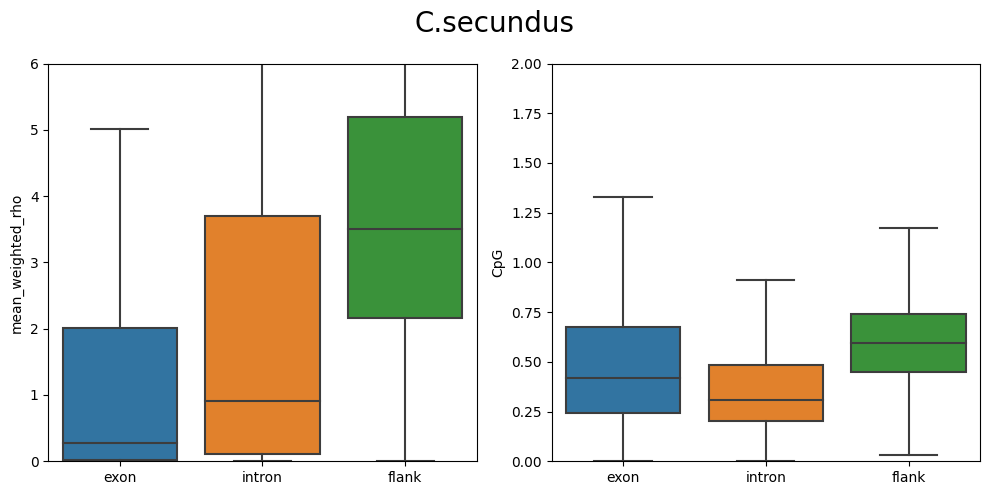

In [43]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.boxplot(data=Csec_melt.loc[Csec_melt.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[Csec_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax)

sns.boxplot(data=Csec_melt.loc[Csec_melt.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[Csec_melt.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', fliersize=0, ax=ax1)
ax.set_ylabel('mean_weighted_rho')
ax1.set_ylabel('CpG')

ax.set_xlabel('')
ax1.set_xlabel('')

ax.set_ylim(0,6)
ax1.set_ylim(0,2)

fig.suptitle('C.secundus', size=20)
plt.tight_layout()
plt.show()

In [99]:
DE_csec_melt.to_csv('./Csec_DE_melt.tsv', sep='\t')

In [100]:
merged_Csec.to_csv('./merged_Csec.tsv', sep='\t')

In [33]:
ft2 = []
for i,k in DE_csec_melt.iterrows():
    if k.variable.startswith('mean'):
        ft2.append('flank')
    else:
        ft2.append(k.featuretype)
DE_csec_melt['ft2'] = ft2

In [38]:
DE_csec_melt.value = DE_csec_melt.value.replace('no_overlap_bin', np.nan).astype(float)

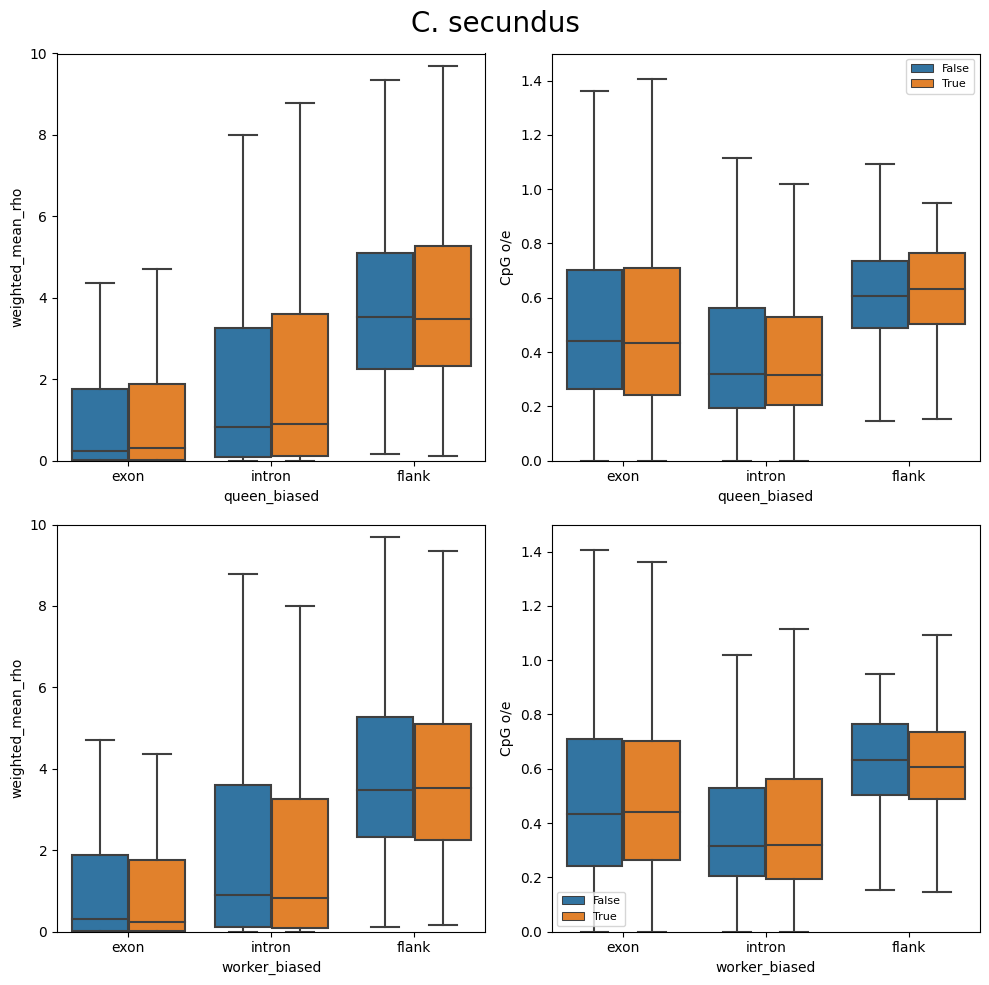

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=False, sharey='col')
for i, k  in enumerate(['queen_biased', 'worker_biased']):
    #ss_de = DE_Mbel_melt.loc[DE_Mbel_melt[k]==True]
    ss_de = DE_csec_melt

    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['weighted_mean_rho_gene','mean_rho_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax= axes[i,0])
    sns.boxplot(data=ss_de.loc[ss_de.variable.isin(['gene_cpg_oe','mean_cpg_flank'])].loc[ss_de.ft2.isin(['exon','intron', 'flank'])], y='value', x='ft2', hue=k, fliersize=0, ax=axes[i,1])
    #sns.boxplot(data=DE_Mbel,y='weighted_mean_rho_gene', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,0])
    #sns.boxplot(data=DE_Mbel,y='gene_cpg_oe', x='featuretype', hue=k, dodge=True, fliersize=0, ax=axes[i,1]) 
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='exon'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'red'}, label='exon')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='intron'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'blue', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'blue'}, label='intron')
    #sns.regplot(data=DE_Mbel.loc[DE_Mbel[k]==True].loc[DE_Mbel['featuretype']=='gene'], x='gene_cpg_oe', y='weighted_mean_rho_gene', ax=axes[i,2], line_kws={'color':'purple', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'purple'}, label='gene')
    
    axes[i,1].legend(fontsize=8)
    axes[i,0].get_legend().remove()
    axes[i,0].set_ylim(0,10)
    axes[i,1].set_ylim(0,1.5)
    axes[i,0].set_xlabel(k)

    axes[i,0].set_ylabel('weighted_mean_rho')
    axes[i,1].set_ylabel('CpG o/e')
    axes[i,1].set_xlabel(k)
    #axes[i,2].set_xlabel(k)
    #axes[i,2].set_ylim(0,10)
    #axes[i,2].set_xlim(0,10)
    #axes[i,2].legend(fontsize=8)
plt.suptitle('C. secundus', fontsize=20)
#plt.savefig('./figures/20230810_Mbel_DE_panel.png',bbox_inches='tight')
#plt.savefig('./figures/20230810_Mbel_DE_panel.svg',bbox_inches='tight')
plt.tight_layout()
plt.show()

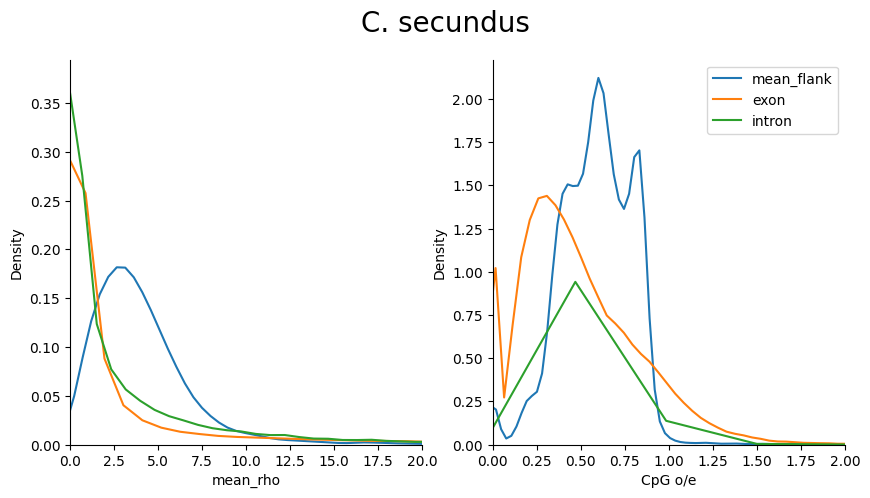

In [51]:
fig, (ax,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='gene'].mean_rho_flank.astype(float), label='mean_flank', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='exon'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='intron'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])


sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='gene'].mean_cpg_flank.astype(float), label='mean_flank', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='exon'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Csec.loc[merged_Csec.featuretype=='intron'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])


plt.legend()
ax1.set_xlim(0,2)

ax.set_xlim(0,20)
plt.suptitle('C. secundus', fontsize=20)
ax1.set_xlabel('CpG o/e')
ax.set_xlabel('mean_rho')
sns.despine()
plt.show()


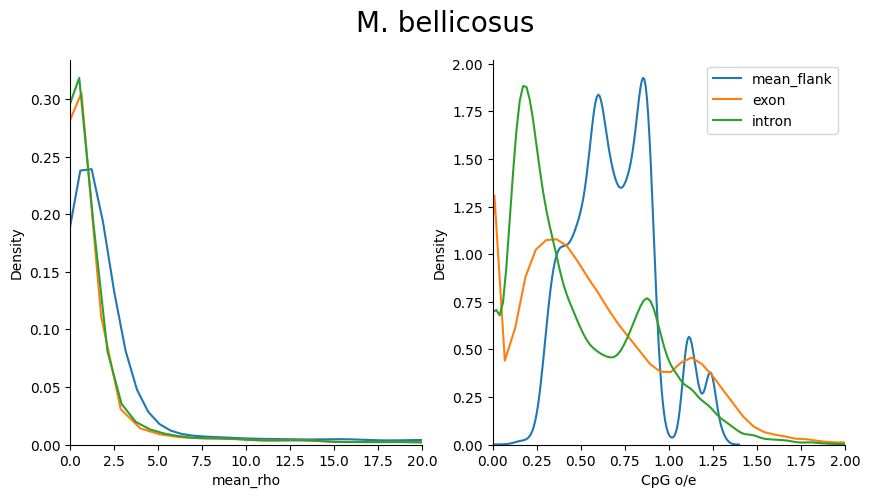

In [52]:
fig, (ax,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='gene'].mean_rho_flank.astype(float), label='mean_flank', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='exon'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='intron'].weighted_mean_rho_gene.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax)   #palette = ['#1b9e77','#d95f02','#7570b3'])


sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='gene'].mean_cpg_flank.astype(float), label='mean_flank', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='exon'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='exon', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])
sns.kdeplot(merged_Mbel.loc[merged_Mbel.featuretype=='intron'].gene_cpg_oe.replace('no_overlap_bin', np.nan).astype(float), label='intron', ax=ax1)   #palette = ['#1b9e77','#d95f02','#7570b3'])


plt.legend()
ax1.set_xlim(0,2)

ax.set_xlim(0,20)
plt.suptitle('M. bellicosus', fontsize=20)
ax1.set_xlabel('CpG o/e')
ax.set_xlabel('mean_rho')
sns.despine()
plt.show()
